<a href="https://colab.research.google.com/github/DSNortsev/Algorithms/blob/master/Project5/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Genetic Algorithm
crossover_rate = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
mutation_rate = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
crossover_method = 'Partially Mapped Crossover' #@param ['Order crossover', 'Maximal Preservative Crossover', 'Partially Mapped Crossover']
mutation_method = 'Swap' #@param ['Swap', 'Insertion', 'Displacement']  
threshold_votes_woc = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
experts_woc = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from random import randrange, sample, random, randint
import networkx as nx
from math import ceil
import numpy as np
import re
import os

class Graph:
    '''
    Graph class that accpets file path as an argument
    '''
    
    def __init__(self, path):
        self.MUTATION_RATE = mutation_rate
        self.CROSSOVER_RATE = crossover_rate
        self.CROSSOVER_METHOD = crossover_method
        self.MUTATION_METHOD = mutation_method
        # WOC threshold inidicates the minimum votes to choose before using greedy algorithm
        # to complete the tour
        self.THRESHOLD_WOC = threshold_votes_woc
        # Percentage expert to vote
        self.EXPERTS_WOC = experts_woc
        # Select 70% of rouets with the minimum cost and 30 randomly
        # Total selection is 100% from population
        self.ELIT_PERCENT = 30
        self.RANDOM_PERCENT = 70
        # Coordinates of all nodes in the graph
        self._coordinates = self.read_tsp_file(path)
        # List of all nodes 
        self._cities = [*self._coordinates.keys()]
        # Total number of nodes
        self._size = len(self._cities)
        # Distances between each nodes in the graph
        self._distances = self.compute_distances()
        # File index to generate a file name of the plot images
        self._file_index = 0
        # Direcotry to keep all plots 
        self._GRAPH_DIR = 'graphs/'
        self.reset_file_index()

        # Mapping dictionary to crossover and mutation methods
        self.__crossovers = {
            'Order crossover': 'order_crossover',
            'Maximal Preservative Crossover': 'maximal_preservative_crossover',
            'Partially Mapped Crossover': 'partially_mapped_crossover'
            }

        self.__mutations = {
            'Swap': 'swap_mutation',
            'Insertion': 'insertion_mutation',
            'Displacement': 'displacement_mutation'
        }   
      
    def reset_file_index(self):
        '''
        This method is reseting the index of the file name when generating graphs and removing all plots  
        '''
        self._file_index = 0
        
        full_path = os.path.abspath(self._GRAPH_DIR)

        for file in os.listdir(self._GRAPH_DIR):
            if file == '.keep':
                continue
            os.remove(os.path.join(full_path, file))  
        return
    

    def read_tsp_file(self, path):
        """"
        Read TSP file
        """
        city_list = []

        with open(path, 'r') as f:
            _data = re.findall(r'\n([0-9].*)', f.read())

        # Split each line by space and convert to float
        for line in _data:
            city_list.append(tuple(map(float, line.split())))
        return { int(vertex): (x,y) for vertex, x, y in city_list }
    
    
    def euclidean_distance(self, cityA, cityB):
        """
        Formula to calculate the Euclidean distance 
        """
        # Math library
        import math
        
        x1 = self._coordinates[cityA][0]
        y1 = self._coordinates[cityA][1]
        x2 = self._coordinates[cityB][0]
        y2 = self._coordinates[cityB][1]
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    
    def compute_distances(self):
        """
        Compute distance method invokes at initialization and calculates the cost of each edge in the graph
        """
        self.distances = defaultdict(dict)
        for cityA in self._cities:
            for cityB in self._cities:
                if cityA != cityB and cityB not in self.distances[cityA]:
                    distance = self.euclidean_distance(cityA, cityB)
                    self.distances[cityA][cityB] = round(distance, 2)
                    self.distances[cityB][cityA] = round(distance, 2)   
        return self.distances

    
    def total_distance(self, tour):
      """
      Calculate total distance by passing completed tour 
      For example: [1, 2, 3, 4, 1]
      """
      total_distance = 0
      for i in range(1, len(tour)):
          total_distance += graph._distances[tour[i-1]][tour[i]]

      # Check if the rout is the closed cycle 
      # if not add the weight to the total destance to frist node
      if tour[0] != tour[-1]:
        total_distance += graph._distances[tour[-1]][tour[0]]
      return round(total_distance, 2)


    def create_route(self):
      '''
      Create route method create a random route from the city list
      '''
      route = sample(self._cities, len(self._cities))
      return route


    def create_init_population(self, population_size):
      '''
      Create initial population method accepts one argument, which is the size 
      of random population to create and return N number of random routes
      '''
      population = []

      for i in range(0, population_size):
        population.append(self.create_route())
      return population


    def rank_routes(self, population):
      '''
      Accepts population list and returns normalized weights
      between 0 and 1
      '''

      fitness_score = {}

      for i, tour in enumerate(population):
        # Since we are interested in lowest distnace
        # we need to devide 1 by total distance
        fitness_score[i] =  1 / (self.total_distance(tour) + 1)
     
      # Calculate total fitness sctore for all routes
      total_score = sum(fitness_score.values())
      
      # Normalize the score and sort it from lowest to highest 
      for k, v in fitness_score.items():
        fitness_score[k] = round(fitness_score[k] / total_score, 4)
      return sorted(fitness_score.items(), key = itemgetter(1), reverse=True)


    def pick_tour(self, fintess_score ):
      '''
      Choose tour based on it is total cost
      '''
      index = 0 
      random_number = random()

      while random_number > 0:
        random_number -= fintess_score[index][1]
        index += 1
        # Pick up the last element if index is greater then total
        if index >= len(fintess_score):
          break
      return fintess_score[index-1]


    def selection(self, fitness):
      '''
      Selection methods accepts list of touple with index and normalized costs\
      and returns a list of indexes of selected routs
      '''
      # ELIT_PERCENT = 30
      # RANDOM_PERCENT = 70
      elit_index = ceil((len(fitness)*self.ELIT_PERCENT)/100)
      result = [tour[0] for tour in fitness[:elit_index]] 

      # Generate population based on RANDOM_PERCENT value
      for i in range(ceil((len(fitness)*self.RANDOM_PERCENT)/100)):  
        result.append(graph.pick_tour(fitness)[0])
      return result

    def mating_pool(self, population, selection_results):
      '''
      Mating pool methods accpets the following argiments:
      - population which is a list of tours 
      - selection results whihc is an index of all selected routs in the tour
      '''
      return [population[i] for i in selection_results]


    # CROSSOVER METHODS
    def order_crossover(self, p1, p2):
      '''
      Use order crossover algorithm to swap cities
      '''
      # Start point in cut
      s = randint(1, len(p1) - 2)
      # End point in cut
      e = randint(s + 1, len(p1))

      c1, c2, p1, p2 = p1[s:e],\
                       p2[s:e],\
                       p1[e:] + p1[:e],\
                       p2[e:] + p2[:e]
      
      c1.extend([i for i in p2 if i not in c1])
      c2.extend([i for i in p1 if i not in c2])
      return c1, c2


    def maximal_preservative_crossover(self, p1, p2):
      '''
      Use maximal preservative algorithm to swap cities
      '''
      # Find how many elemets to swap
      c = len(p1) // 2
      # Find starting point
      r = randrange(len(p1) + 1)
      # Extend the list, which will allow to move back to index 0
      c1, c2 = (p1 * 2)[r:r + c], (p2 * 2)[r:r + c]
        
      c1.extend([i for i in p2 if i not in c1])
      c2.extend([i for i in p1 if i not in c2])
      return c1,c2


    def partial_mapping(self, p, c, s, e):
      '''
      Method accepts 4 argumets: p - parent, c - child, s - start index
      e - end index,  and open 40% of genes in child 
      '''
      # Genearte a set of all parent indices
      p_index = set(range(len(p)))
      # Generate a set of cut indeces
      cut_index = set(range(s,e))
      # Find differnce of indices
      left_index = list(p_index - cut_index)
      # Find 40% of indices to open 
      total_open = ceil(len(left_index) * 0.4)
      # Get Random indices
      random_index = sample(left_index, total_open)
      # Open indices in child tour
      for i in random_index:
        if p[i] not in c:
          c[i] = p[i] 
      return c


    def partially_mapped_crossover(self, p1, p2):
      # Find start and end index
      s = randint(1, len(p1) - 2)
      e = randint(s + 1, len(p1))

      # Swap cut part between parents
      c1, c2 = [0] * len(p1), [0] * len(p2)
      c2[s:e], c1[s:e] = p1[s:e], p2[s:e]

      # Open partial genes 
      c1 = self.partial_mapping(p1, c1, s, e)
      c2 = self.partial_mapping(p2, c2, s, e)
      
      # Complete tour
      for i in p2:
        if i not in c1:
          c1[c1.index(0)] = i

      for i in p1:
        if i not in c2:
          c2[c2.index(0)] = i
      return c1, c2


    # MUTATION ALGORITHMS
    def swap_mutation(self, tour):
      '''
      Swap mutation method accepts one argument, which is a generated
      tour by selection.
      
      To perform swap mutation select two alleles at random and
      swap their positions. It preserves most of the adjacency
      information but links broken disrupts order more
      '''
      i, j = sample(range(len(tour)),2)
      tour[i], tour[j] = tour[j], tour[i]
      return tour

    
    def insertion_mutation(self, tour):
      '''
      Insertion mutation method accepts one argument, which is a generated
      tour by selection.

      It is used in Permutation encoding. First of all, pick two allele values
      at random. Then move the second allele to follow the first, shifting the
      rest along to accommodate. Note that this preserves most of the order 
      and the adjacency information
      '''
      random_city, random_position = sample(range(len(tour)),2)
      city = tour.pop(random_city)
      tour.insert(random_position, city)
      return tour


    def displacement_mutation(self, tour):
      '''
      Displacement mutation method accepts one argument, which is a generated
      tour by selection.

      Displacement mutation inserts a random string of cities in another 
      random place. 
      '''

      # Find start and end index
      s = randint(1, len(tour) - 2)
      e = randint(s + 1, len(tour))

      random_position = randint(0, len(tour))
      substring = tour[s:e]
      tour = tour[:s] + tour[e:]
      return tour[:random_position] + substring + tour[random_position:]

    
    def create_new_generation(self, current_generation, woc = False):
      # Find the name of crossover and mutation methods to use
      crossover = self.__crossovers[self.CROSSOVER_METHOD]
      mutation = self.__mutations[self.MUTATION_METHOD]
      # Create a list of indices from population with normalized weights
      fitness = graph.rank_routes(current_generation)
      best_route = current_generation[fitness[0][0]]
        
      # SELECTION STEP
      # Select method chooses 100% of current population when 30% is routs with
      # best costs and 70% is random with high probabilty of best routes 
      selection_result = graph.selection(fitness)
      # Generate a mating pool from current population based on indices from
      # selection result 
      mating_pool = graph.mating_pool(current_generation, selection_result)
    
      next_generation = []

      # CROSSOVER STEP
      for pair in zip(mating_pool[::2], mating_pool[1::2]):
          next_generation.extend(getattr(self, crossover)(*pair)\
                                 if random() < self.CROSSOVER_RATE else pair)
      # MUTATION STEP
      next_generation = [getattr(self, mutation)(tour)\
                         if random() < self.MUTATION_RATE else tour\
                         for tour in next_generation]


      # Order the generation according to the fitness value
      next_generation = sorted(next_generation, key=self.total_distance)

      # Find best tour by using WOC algorithms with specified expert percentage from population
      if woc:
        woc_tour = self.woc_algorithm(next_generation[:int(self.EXPERTS_WOC * len(next_generation))])
        # print(f'WOC TOUR: {woc_tour}')

        if woc == 'include':
          # Replace the last tour in next generation with WOC tour
          next_generation[-1] = woc_tour
          # Next generation needs to be sorted again after WOC tour was added
          next_generation = sorted(next_generation, key=self.total_distance)

        # Build result with next generation
        result = {'next_generation': next_generation,
                  'genetic_output': {'best_route': next_generation[0],
                                      'total_cost': self.total_distance(next_generation[0])},
                  'woc_output': {'best': woc_tour,
                                 'total_cost': self.total_distance(woc_tour)}
          }
      else:
          result = {'next_generation': next_generation,
                    'genetic_output': {'best_route': next_generation[0],
                                       'total_cost': self.total_distance(next_generation[0])}
          }
  
      # best_route = next_generation[0]
      # total_cost = self.total_distance(best_route)
      # print(f'Best Tour: {best_route}')
      # print(f'Best Tour cost: {total_cost}')
      # print(f'WCO tour: {woc_tour}')
      # print(f'WCO cost: {self.total_distance(woc_tour)}\n')

        
      # return next_generation, best_route, total_cost
      return result


    def greedy_algorithm(self, path):
      '''
      Gread algortithm find the the next city in the best based on min cost.
      Accepts:
      - path which is incomplete path 
      '''
      # Find all missing nodes but set difference
      missing_nodes = list(set(self._cities) - set(path))
      # Set last node in path as next element 
      nxt_elmt = path[-1]

      while len(missing_nodes) != 0 :
        # Run while loop till all nodes are added to the path
        # Find the cost of missing nodes
        cost = {k:v for k, v in self._distances[nxt_elmt].items() if k in missing_nodes}
        # Get next element with min cost
        nxt_elmt = min(cost.items(), key = itemgetter(1))[0]
        # Append node to the path
        path.append(nxt_elmt)
        # Remove next element from missing nodes
        missing_nodes.remove(nxt_elmt)
        # print(f'Cost: {cost},\n Next element: {nxt_elmt}')
        # print(f'Path: {path}')
        # print(f'Missing nodes: {missing_nodes}\n')
      return path 


    def woc_find_next_node(self, matrix, next_element, path, row = [], column = []):
        '''
        Wco_find_next_node method lookes for the next node in
        matric's row and columns based on max votes count

        '''
        # This function is using global variables
        # global lmatrix, next_element, row_index, column_index, path
        # local lmatrix, next_element, row_index, column_index, path

        # Check if row or column is set to True 
        if len(row) == 0 and len(column) == 0:
          return False
        
        # Based on passed value, create iterator row or column
        node_list = row if len(row) != 0 else column

        # Node list contains indecis with the max value which also represents next node
        for node in node_list:
          if len(row) != 0:
            matrix[next_element, node] = 0
          else:
            matrix[node, next_element] = 0
          if node not in path and node != 0:
            # If node is not in the path that append it to the path and use it to find 
            # the next node based on the votes count
            # print(f'Node {node} NOT in the path row')
            path.append(node)
            next_element = node
            # print(f'Path: {path}, Next element: {next_element}')
            break
          # Node is already in the path continue
          # print(f'Path: {path}, Node {node} in the path row')
          continue 
        return True


    def woc_algorithm(self, population):
      '''
      WCO algorithm finds best path based on total edge counts from
      population. 
      It accepts one argumet population which is population of experts 
      '''

      # Create a matrix with zeros where, where the frist column and row are not in used
      matrix = np.zeros(shape=(graph._size + 1,graph._size + 1))

      # Populate the matrix with edge counts
      for path in population:
        for i in range(0,len(path) -1):
          # Populate upper and lower triangle sides
          matrix[path[i],path[i + 1]] = matrix[path[i],path[i + 1]] + 1
          matrix[path[i + 1],path[i]] = matrix[path[i + 1],path[i]] + 1
          # print(f'{path[i]} - {path[i + 1]}')

      # matrix[2,2] = 10
      # print(matrix)
      # print(np.tril(matrix, -1))
      # Use lower triangle side since the upper side is symetrical
      # The one side is used to save memory
      matrix = np.tril(matrix, -1)
      # Only get from from matrix that does not exceed max votes threshold
      # Multiple the maximam votes in matrix with set threshold 
      max_votes_threshold = int(np.amax(matrix) * self.THRESHOLD_WOC)
      # print(f'MAX VOTES THRESHOLD: {max_votes_threshold}')
      # Find the first edge with the highest votes
      path = [city[0] for city in np.where(matrix == np.amax(matrix))]
      # print(path)
      # Mark edge with 0 votes in matrix
      matrix[path[0], path[1]] = 0
      # Start with second element in the path
      next_element = path[-1]

      while len(path) < len(population[0]):
        # Get the row of the node in matrix
        row = matrix[next_element, :]
        # Get the column of the node in matrix
        column = matrix[:, next_element]
        # print(matrix[next_element, :])
        # print(matrix[:, next_element])
        # print(matrix)
        # Find the maximum value in row 
        max_row = np.amax(matrix[next_element, :])
        # Find the maximum value in column
        max_column = np.amax(matrix[:, next_element])
        # print(max_row)
        # print(max_column)
        # Find all indecis for the maximum value in row
        row_index = np.where(row == max_row)[0]
        # Find all indecis for the maximum value in column
        column_index = np.where(column == max_column)[0]
        # print(row_index)
        # print(column_index)
        # print(matrix)

        # If maximum value in row and column is less than the threshold 
        # use greedy heuristic
        if max_row <= max_votes_threshold and max_column <= max_votes_threshold:
        # if not (int(max_row) or int(max_column)):
          self.greedy_algorithm(path)
          break
        
        if max_row >= max_column:
          # Find next element in row
          self.woc_find_next_node(matrix, next_element, path, row = row_index)
        else:   
          # Find next element in column
          self.woc_find_next_node(matrix, next_element, path, column = column_index)

      return path 


    def genetic_algorithm(self, pop_size=10, term_count=100 , woc = False):
      '''
      Genetic algorithm method accepts the following arguments:
      - pop_size is the size of random initial tours, Default value is 100
      - term_count indicates when to terminate an algorithms after not seeing improving
        in total cost
      - woc is boolean variable indicates if woc algorithm needs to be applied
            False - if WOC doesn't need to be applied
            guess - run WOC, but not add the tour to next generation 
            include - run WOC and includ tour in next generation

      '''
      # Generate initial population 
      population = self.create_init_population(pop_size)
      # Instanciate total cost as infinity value
      total_cost = float('inf')
      # Count generation when there is no improvements
      term_index = 0
      # Count total generation 
      generations = 0
      # All selected best routes
      best_routes = []
      progress_ga = []
      progress_woc = []
        
      # Run while loop till there is no improvements in "term_count" times 
      while term_index <= term_count:
        generations += 1
        result = self.create_new_generation(population, woc)
        population = result['next_generation']
        progress_ga.append(result['genetic_output']['total_cost'])
        if woc:
          progress_woc.append(result['woc_output']['total_cost'])

        if result['genetic_output']['total_cost'] < total_cost:
            best_route = result['genetic_output']['best_route']
            total_cost = result['genetic_output']['total_cost']
            # Create a list of tuples that contains the best route which is
            # completed cycle, total weights and number of total generations
            # best_routes.append((result[1] + [result[1][0]], result[2], generations))
            best_routes.append((best_route + [best_route[0]],
                               result['genetic_output']['total_cost'],
                               generations))
            term_index = 0
        else:
          term_index += 1


        # population = result[0]
        # progress.append(result[2])
        # if result[2] < total_cost:
        #     best_route = result[1]
        #     total_cost = result[2]
        #     # Create a list of tuples that contains the best route which is
        #     # completed cycle, total weights and number of total generations
        #     best_routes.append((result[1] + [result[1][0]], result[2], generations))
        #     term_index = 0
        # else:
        #   term_index += 1
      return best_routes, progress_ga, progress_woc


    def draw_plot(self, tour_info, weights=False): 
        '''
        Draw plot methods accepts the following argumetns:
        - tour_info variable, which contains a list of tuples of route, route cost and total generations
        - weights, when set to true addes weigths to each graph
        '''
        tour = tour_info[0]
        tour_cost = tour_info[1]
        total_generations = tour_info[2]
        # Create new graph
        G = nx.Graph()
        pos = self._coordinates
        # Image name
        file_name = f'{self._file_index:0{len(str(self._size))}d}'

        # Add edges to the graph
        for i in range(len(tour)-1):
            G.add_edge(tour[i], tour[i+1], weight = self._distances[tour[i]][tour[i+1]])

        # Display weights of each edge
        if weights: 
            # Get weight for each edge 
            labels = nx.get_edge_attributes(G,'weight')
            # Drow weights to each edge
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

        # Add nodes 
        options = {"node_size":200, "alpha": 0.5}
        nx.draw_networkx_nodes(G, pos, nodelist=list(pos.keys()), node_color="r", **options)

        # Draw in red edges that are not in shortest path
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=G.edges(),
            width=0.5,
            alpha=0.5,
            edge_color="r",
        )

        # Draw lables in the node
        nx.draw_networkx_labels(G,pos, font_size=10)

        # Increase the size of the plots
        fig = plt.gcf()
        fig.set_size_inches(18, 10.5)
        #plt.figure(1,figsize=(50,50))

        plt.axis("off")
        plt.title(f'Genetic Algorithm\nTotal Cost: {tour_cost}\n Total Generations: {total_generations}')
        plt.savefig(f'graphs/project_4_{file_name}.png')
        plt.show()
        # Generate the file name in ascending order 
        self._file_index += 1

In [ ]:
# Plot all nodes in the graph 
import matplotlib.pyplot as plt
import os
import imageio


def plot_nodes(graph):
  x = [coord[0] for coord in graph._coordinates.values()]
  y = [coord[1] for coord in graph._coordinates.values()]

  plt.scatter(x, y, color='red')
  plt.show()

def plot_ga_and_woc(result):
  plt.plot(results[1], color='red', label='GA best route')
  plt.plot(results[2], color='blue', label='WOC best route')
  plt.ylabel('Distance')
  plt.xlabel('Generation')
  plt.title('Best route GA/ GA with WOC')
  plt.legend()
  plt.savefig(f'best_routes_ga_and_woc_11_cities.png')
  plt.show()

def create_gif(gif_name):
  # Generate gif images from png plots
  images_dir = 'graphs'
  image_list = []

  # Generate a list of absolute paths to the png images
  filelist= sorted([os.path.abspath(f'{images_dir}/{file}') for file in os.listdir(images_dir) if file.endswith('.png')])
  for file_name in filelist:
      image_list.append(imageio.imread(file_name))
      
  # Create gif file 
  kargs = { 'duration': 0.3 }
  imageio.mimwrite(gif_name , image_list, **kargs)



## TSP with 11 cities

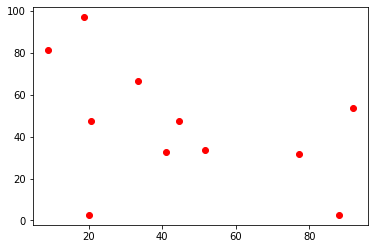

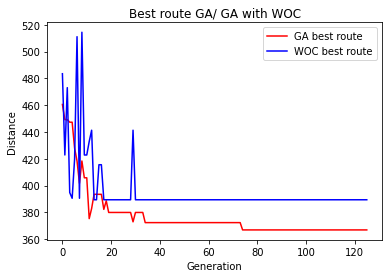

CPU times: user 645 ms, sys: 5.96 ms, total: 651 ms
Wall time: 654 ms


In [ ]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random11.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(357.55, 40)
(354.88, 31)
(359.56, 19)
(354.88, 16)
(354.88, 40)
(366.06, 37)
2 loops, best of 3: 84 ms per loop


In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(351.05, 39)
(351.05, 17)
(351.05, 57)
(351.05, 63)
(354.88, 57)
(351.05, 24)
2 loops, best of 3: 184 ms per loop


In [ ]:
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [9, 2, 11, 8, 10, 3, 7, 1, 6, 4, 5, 9]
Total cost: 351.05
Total number generations: 50


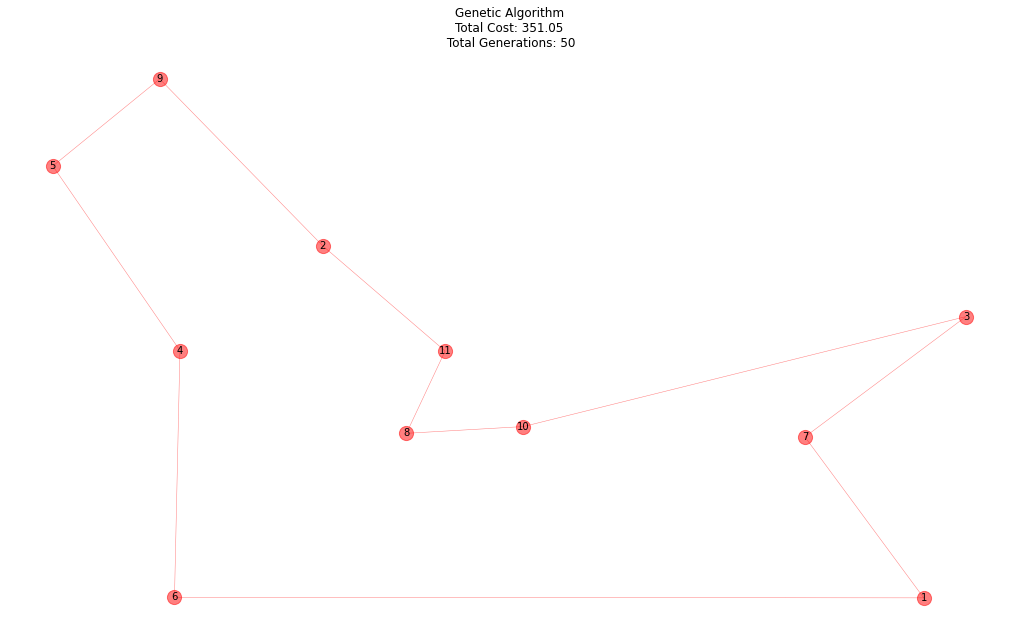

In [ ]:
graph.draw_plot(results[0][-1], weights=False)

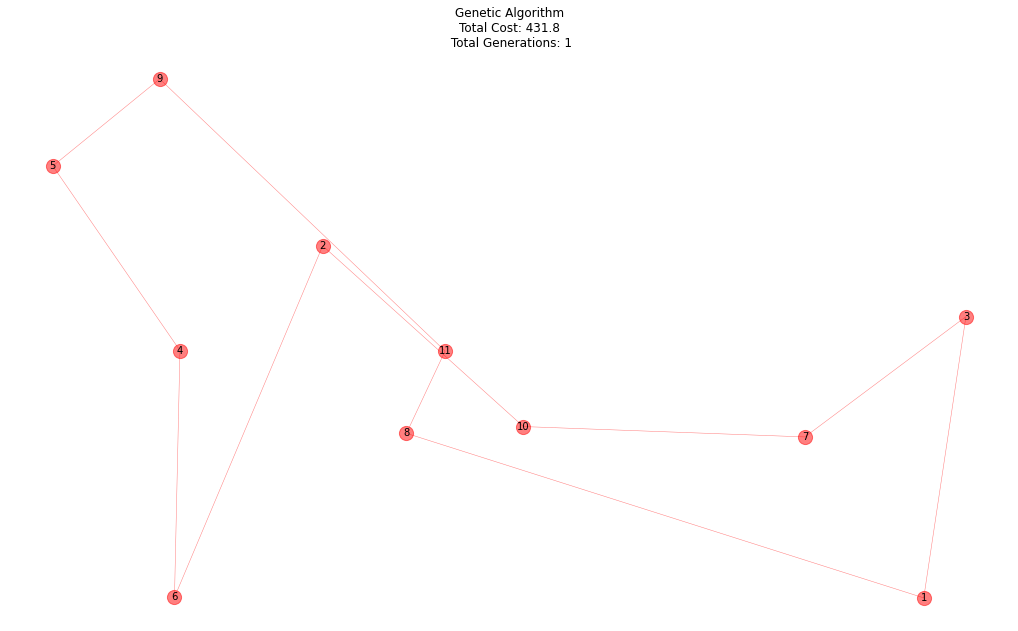

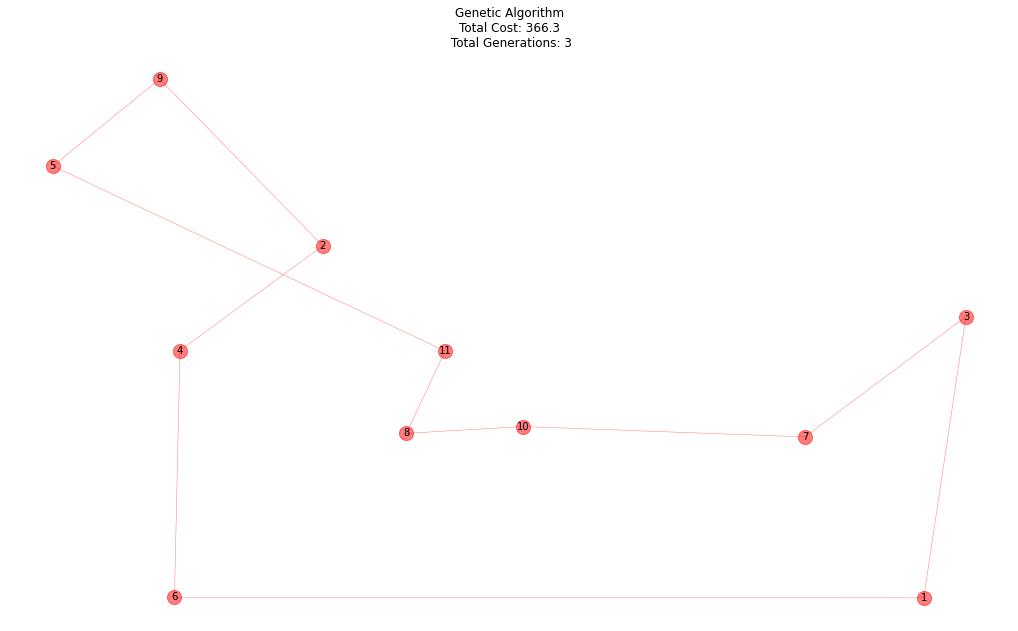

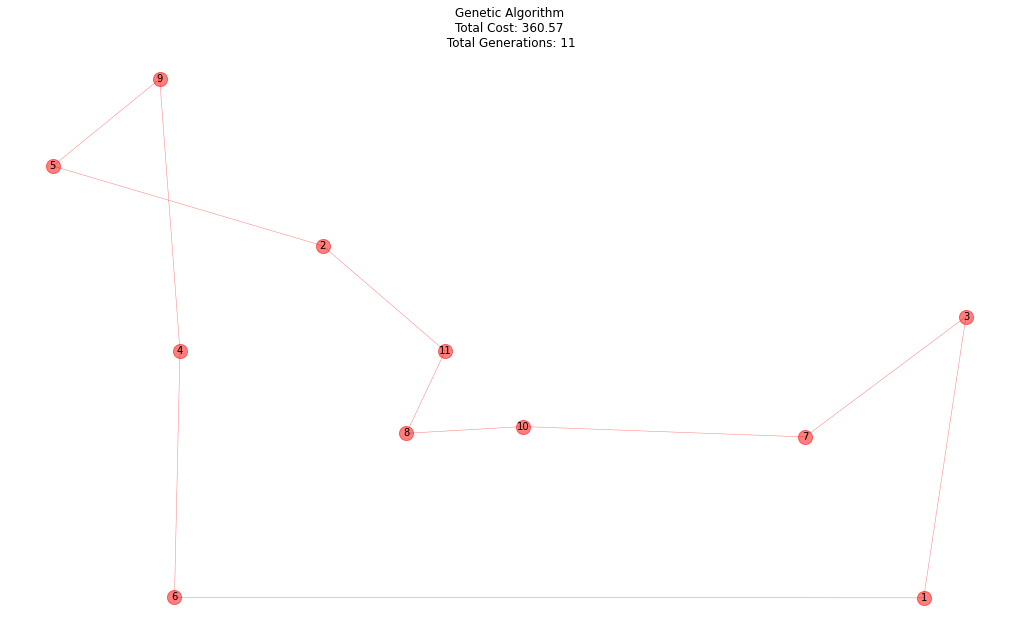

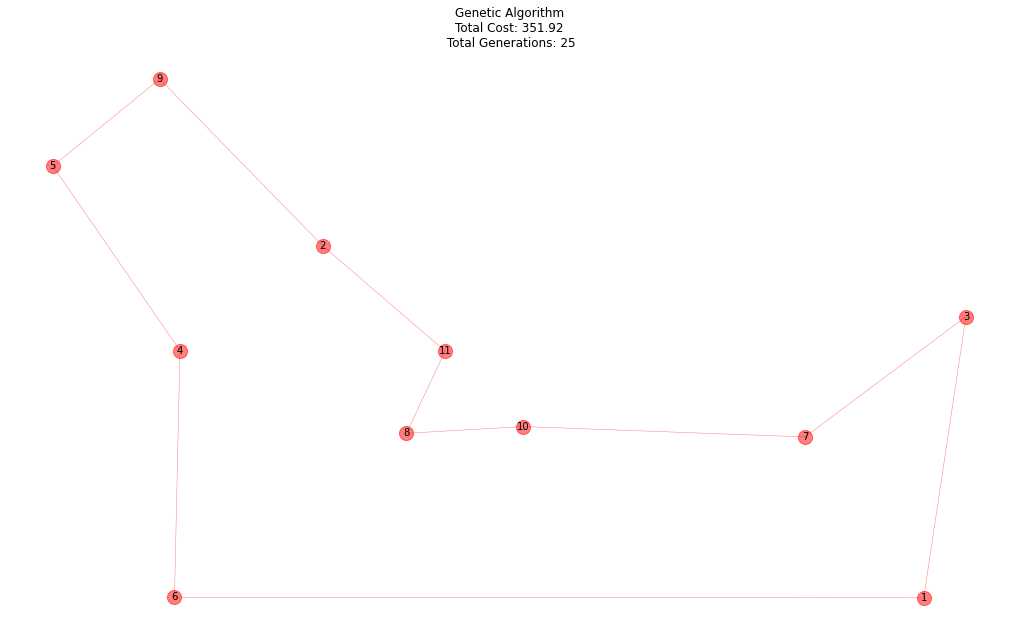

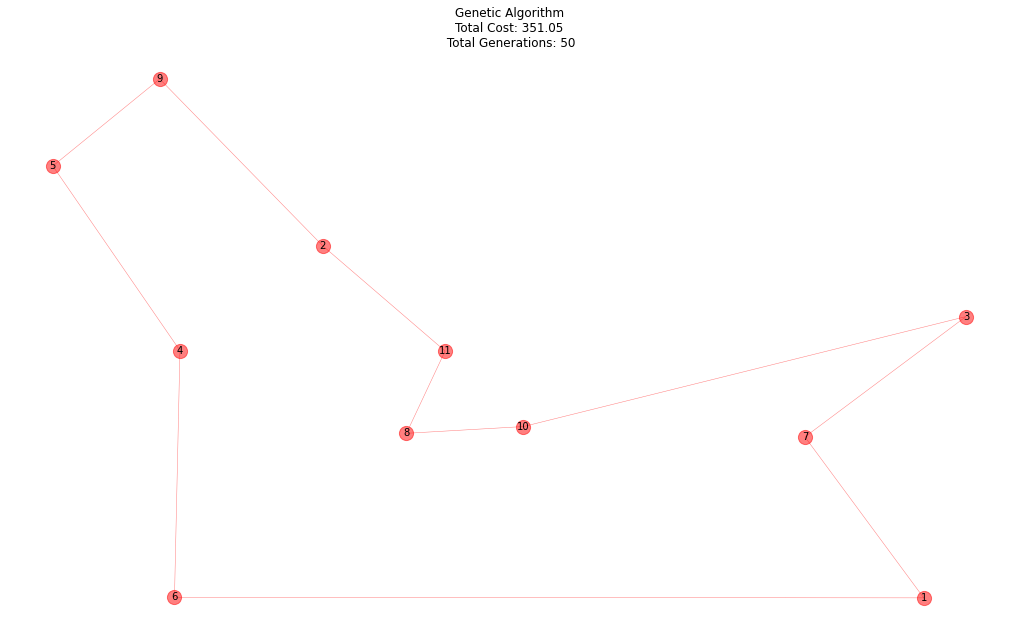

In [ ]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_11.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_11.gif?raw=1)

## TSP with 22 cities

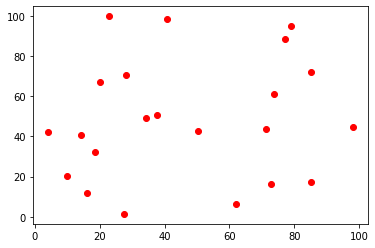

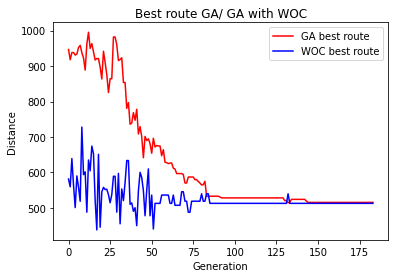

CPU times: user 860 ms, sys: 6.04 ms, total: 866 ms
Wall time: 872 ms


In [ ]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random22.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(512.79, 101)
(485.22, 103)
(419.22, 153)
(418.49, 118)
(437.18, 118)
(471.71, 306)
2 loops, best of 3: 300 ms per loop


### Best cost with WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(439.64, 33)
(425.53, 4)
(427.09, 100)
(454.86, 2)
(466.04, 29)
(503.23, 1)
2 loops, best of 3: 271 ms per loop


In [ ]:
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [15, 3, 16, 11, 7, 1, 5, 6, 12, 17, 21, 8, 10, 13, 19, 4, 9, 14, 2, 18, 22, 20, 15]
Total cost: 434.36
Total number generations: 73


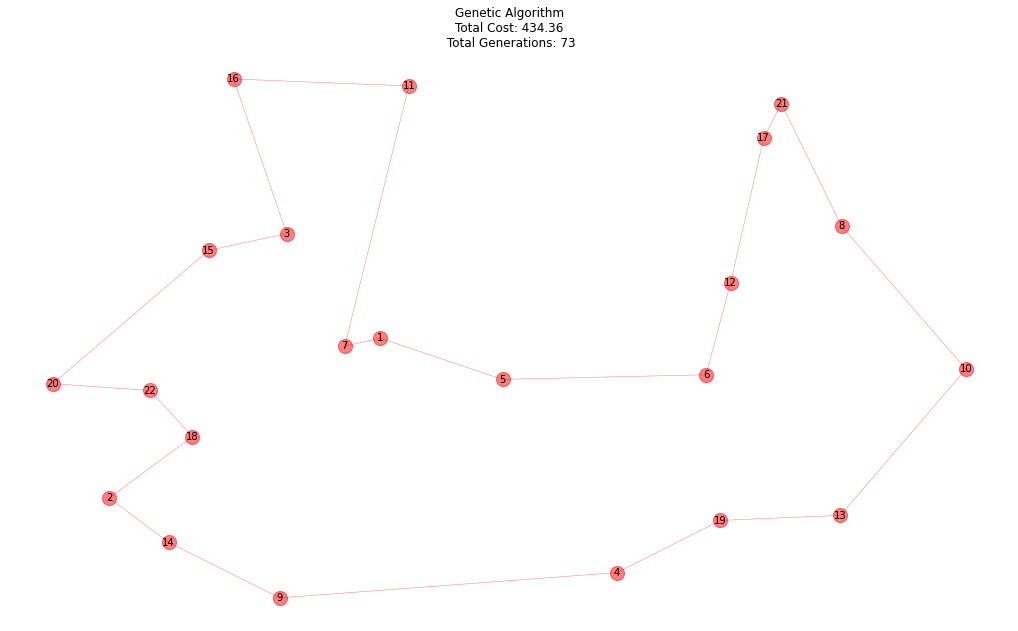

In [ ]:
graph.draw_plot(results[0][-1], weights=False)

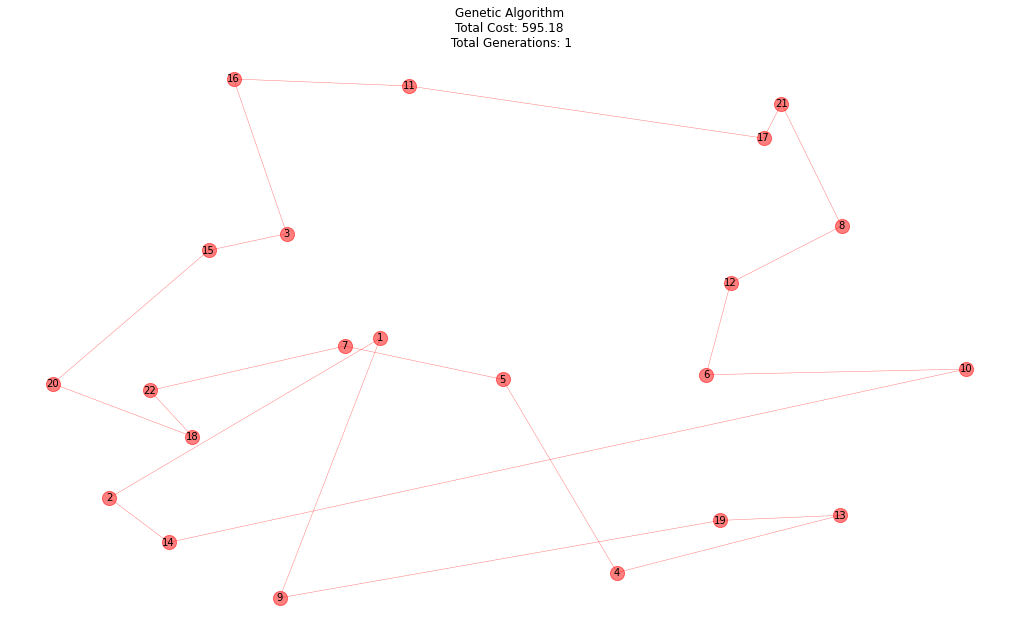

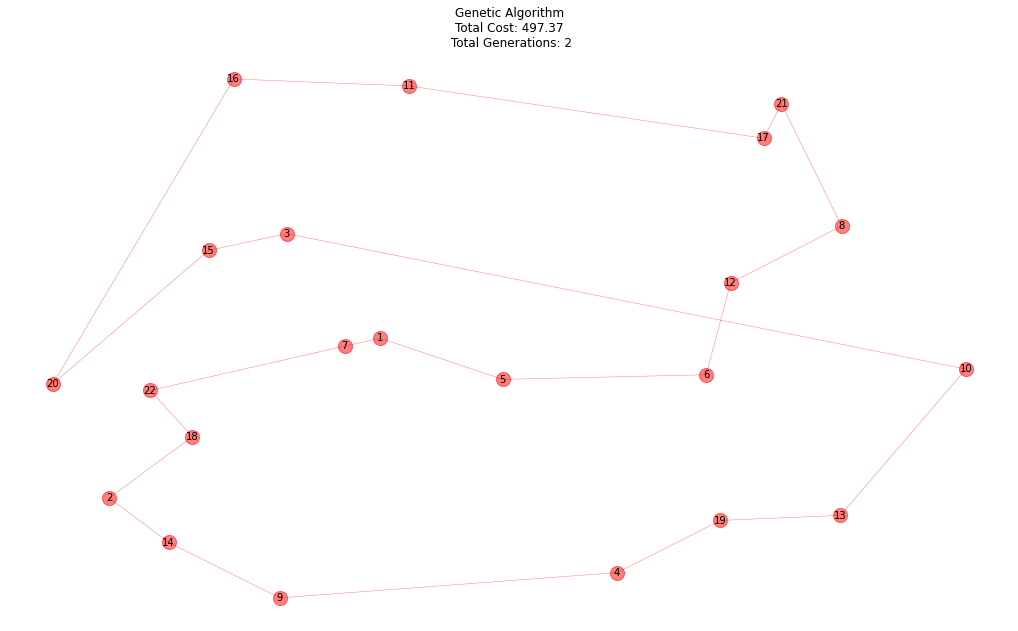

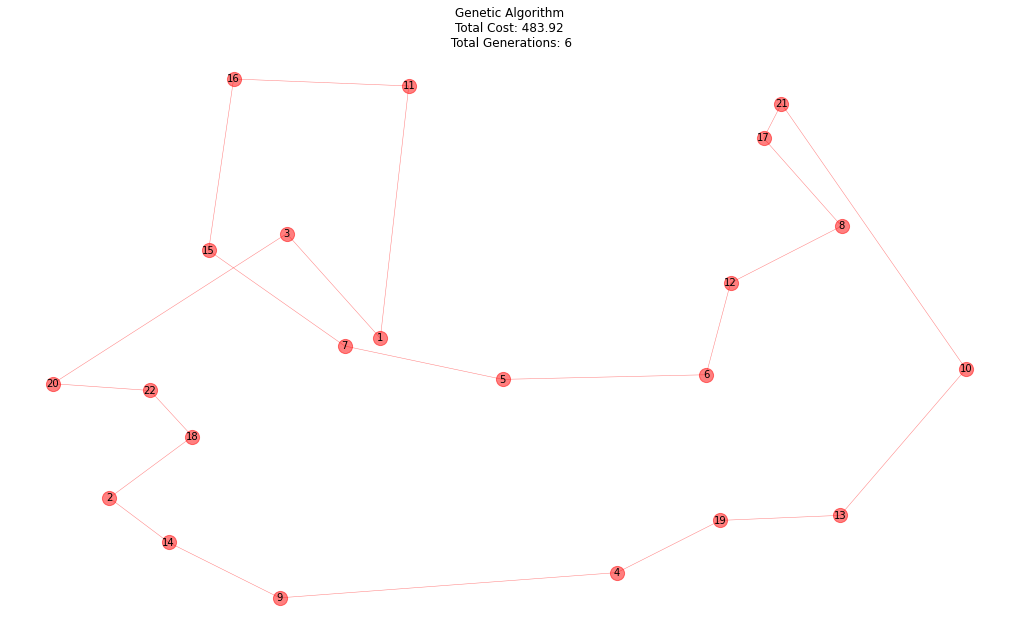

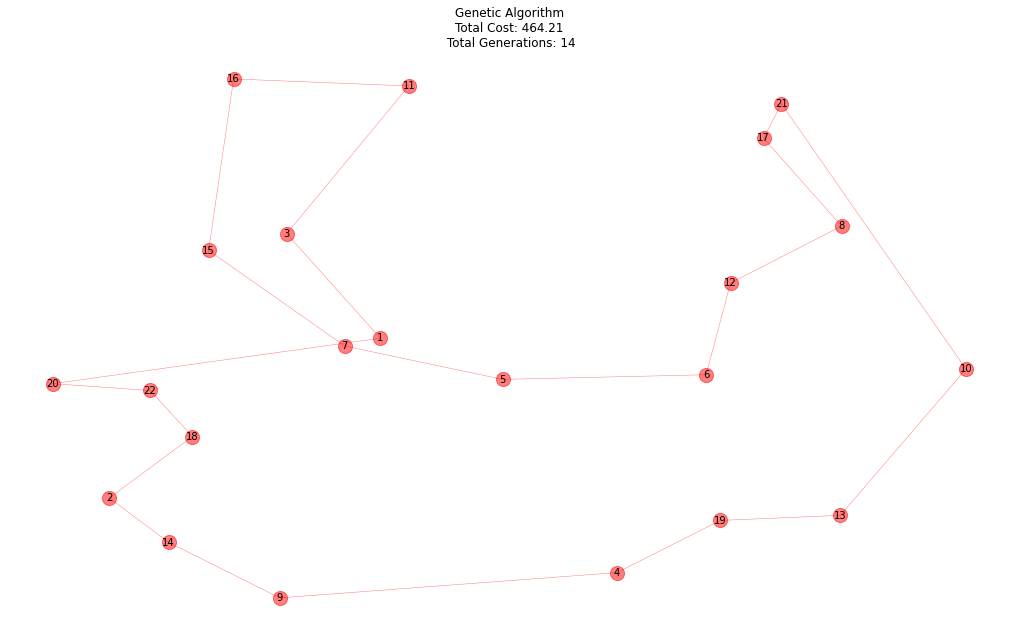

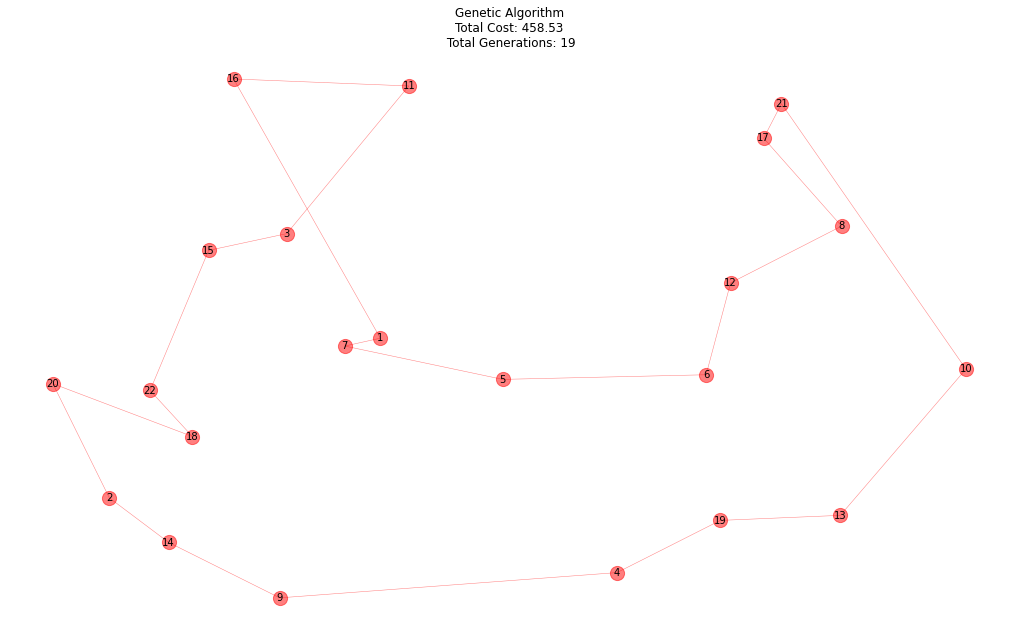

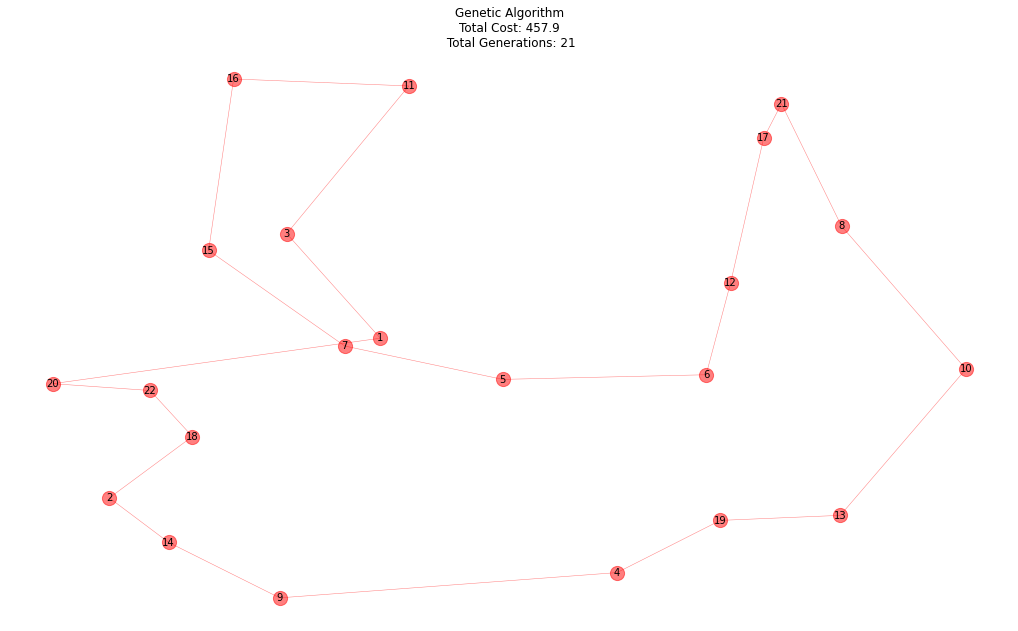

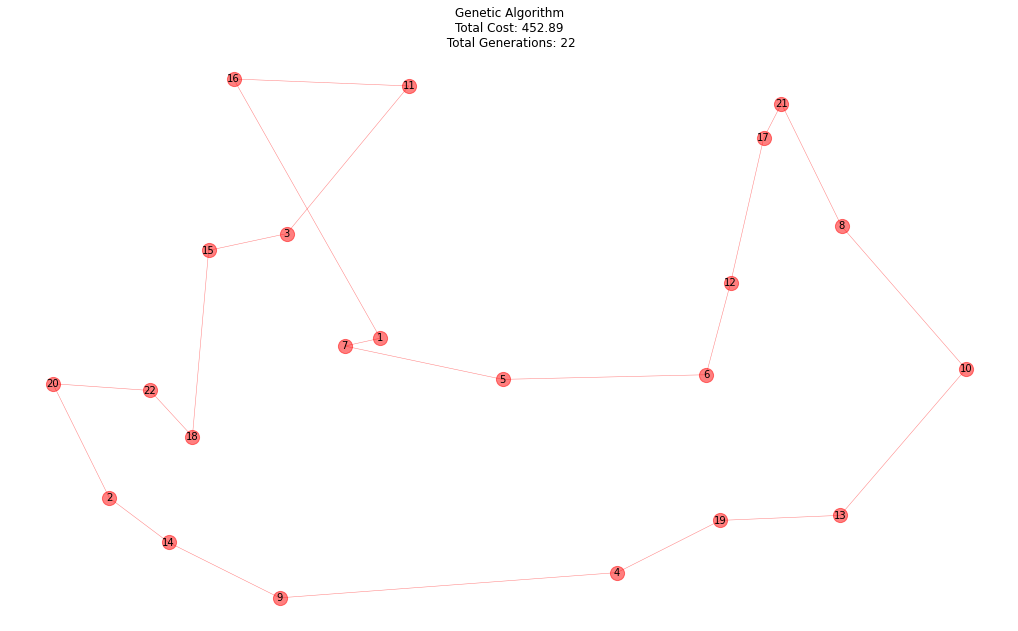

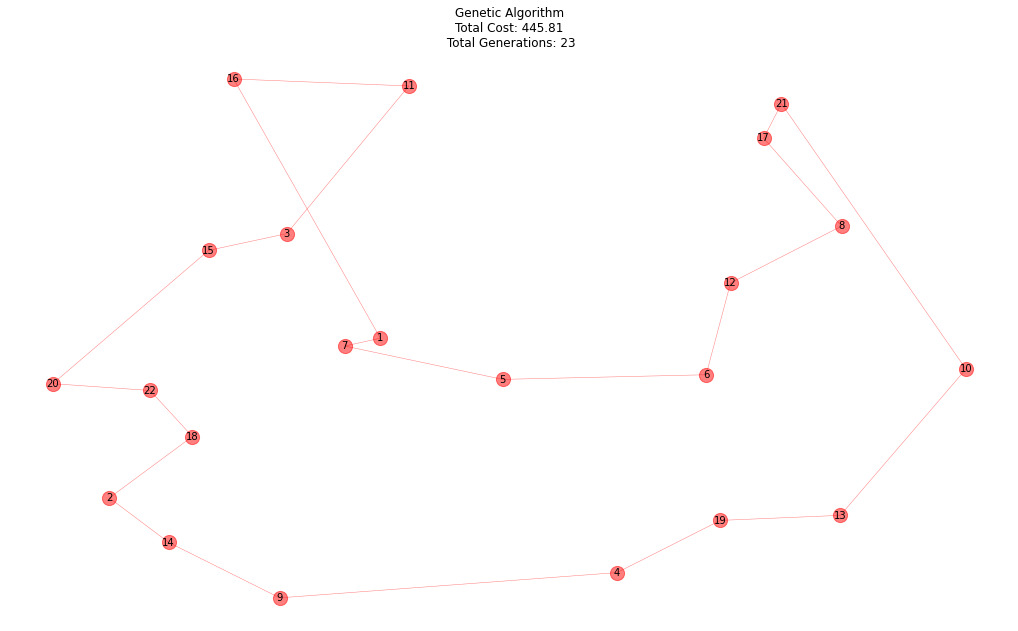

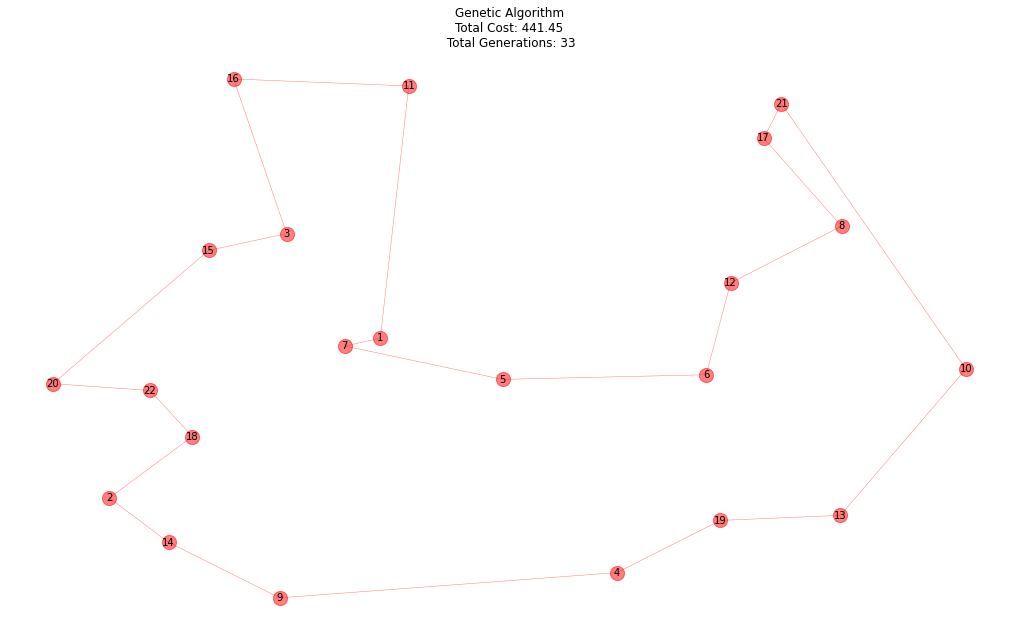

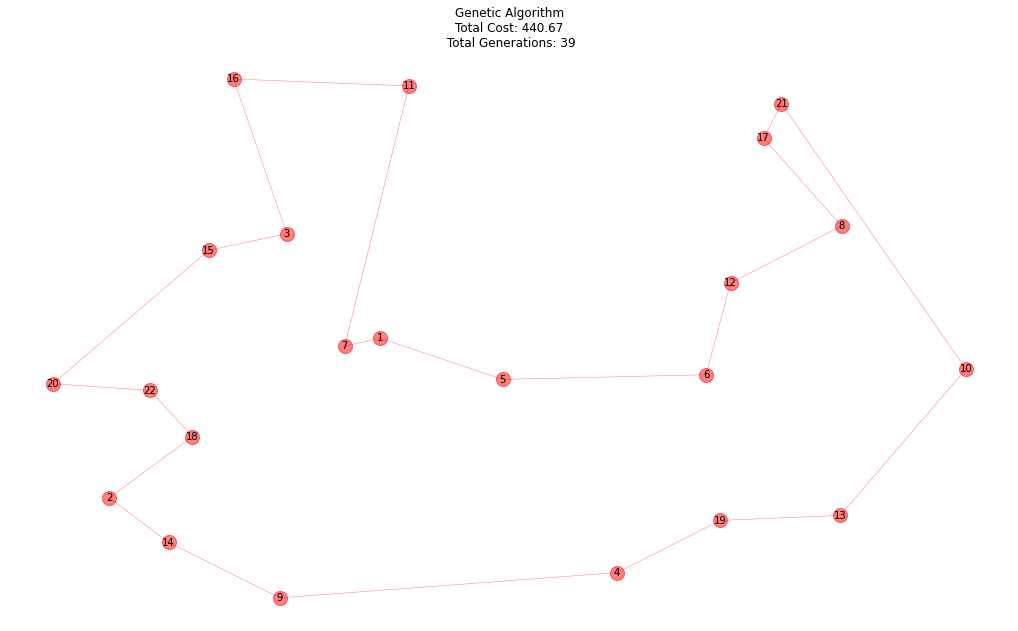

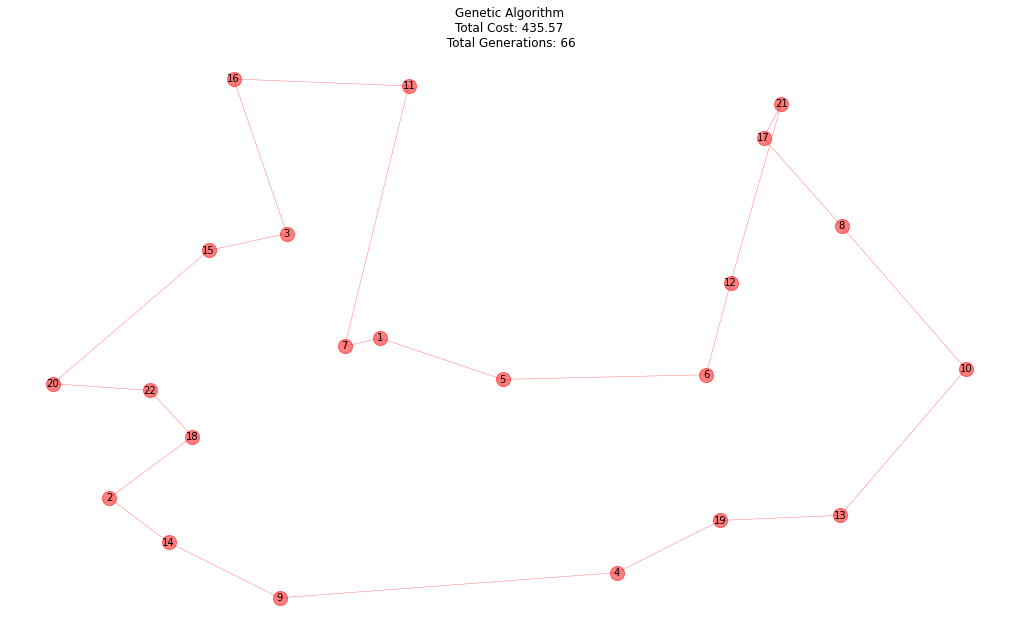

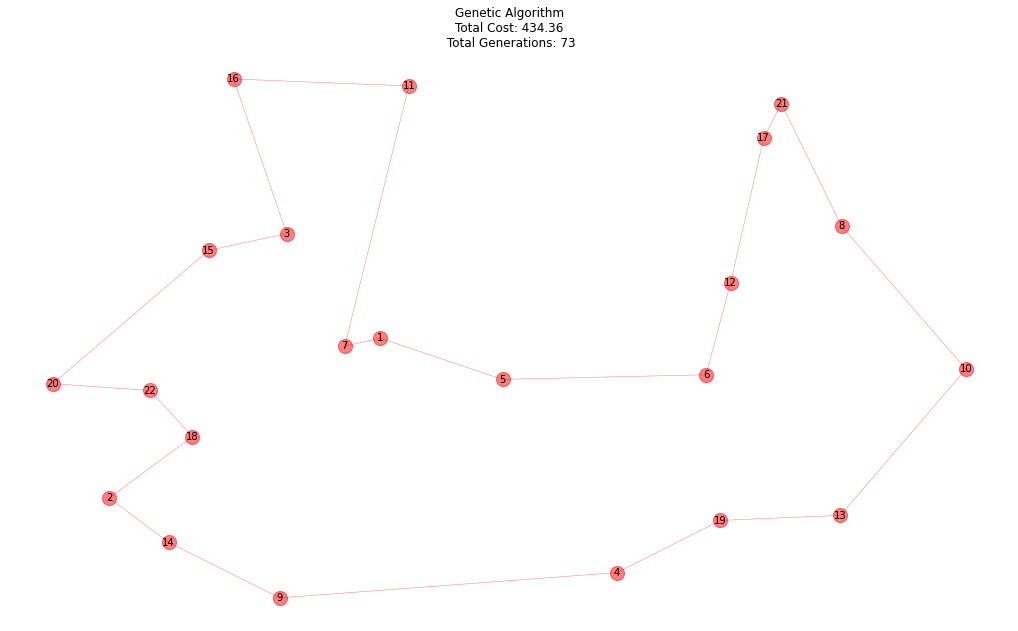

In [ ]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_22.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_22.gif?raw=1)


## TSP with 44 cities

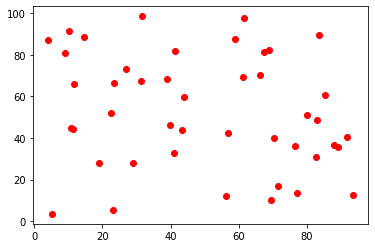

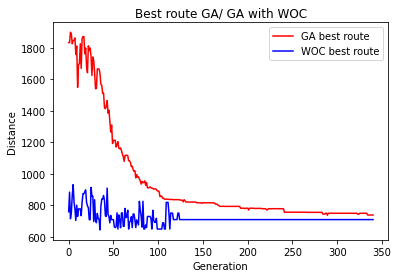

CPU times: user 1.96 s, sys: 12.7 ms, total: 1.98 s
Wall time: 1.98 s


In [ ]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random44.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(687.32, 374)
(793.52, 520)
(741.6, 464)
(833.7, 275)
(809.95, 408)
(781.09, 176)
2 loops, best of 3: 1.21 s per loop


### Best cost with WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(661.69, 29)
(648.58, 23)
(648.58, 12)
(691.47, 2)
(648.58, 4)
(622.43, 48)
2 loops, best of 3: 460 ms per loop


In [ ]:
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [4, 5, 6, 8, 20, 33, 3, 42, 41, 37, 36, 14, 16, 15, 43, 17, 44, 29, 9, 25, 11, 24, 34, 32, 19, 12, 30, 28, 22, 1, 13, 21, 18, 2, 26, 31, 23, 7, 27, 35, 10, 39, 40, 38, 4]
Total cost: 588.99
Total number generations: 202


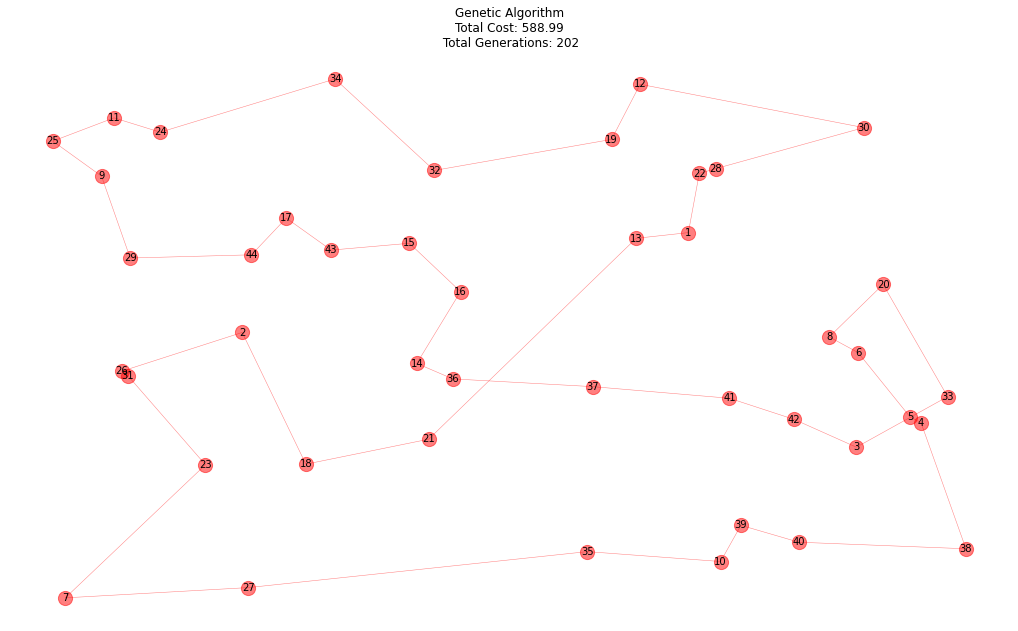

In [ ]:
graph.draw_plot(results[0][-1], weights=False)

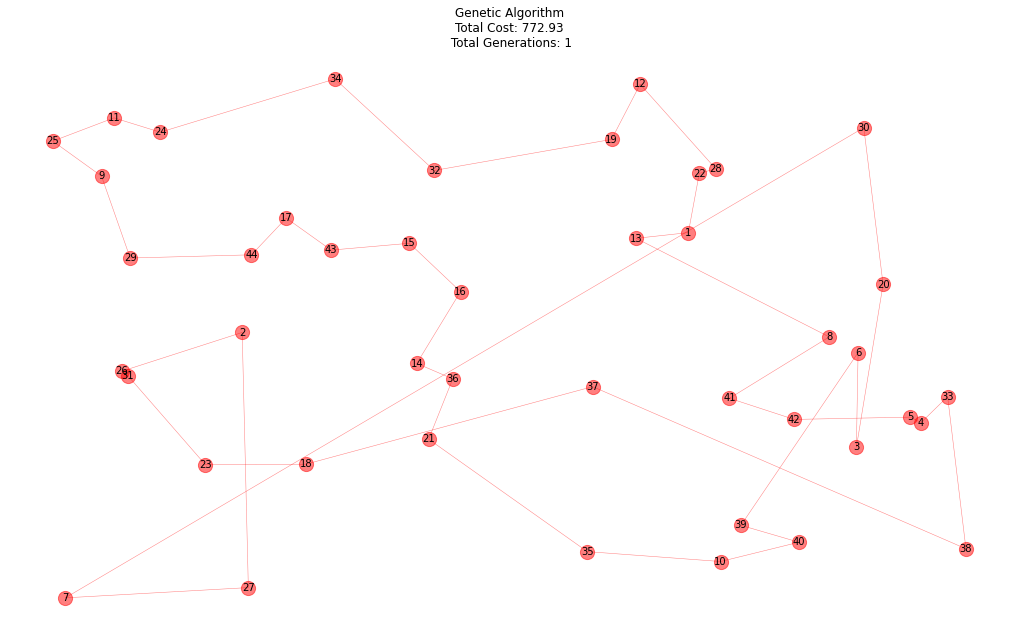

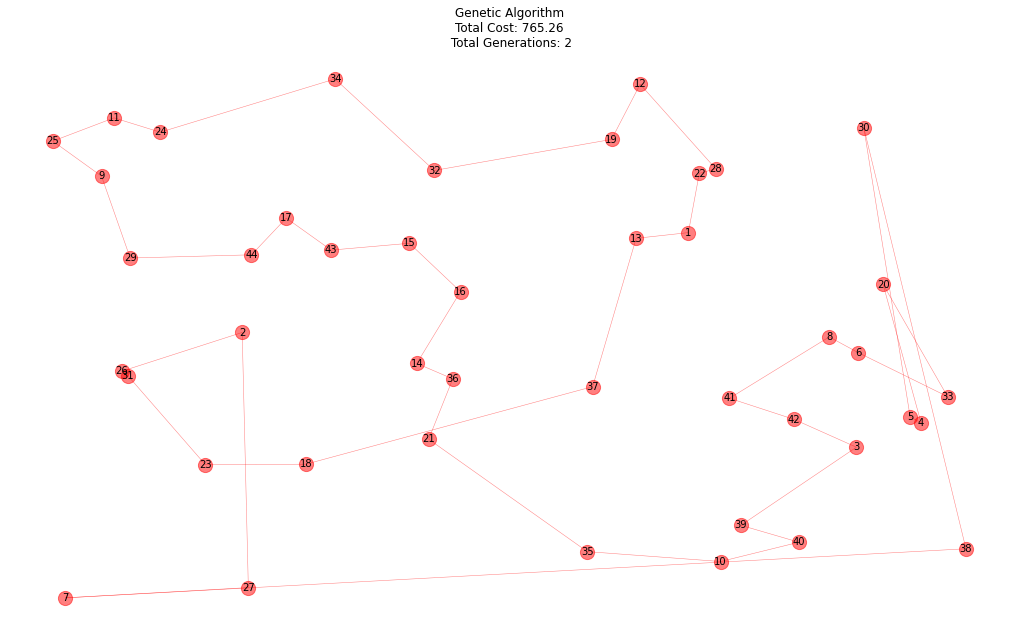

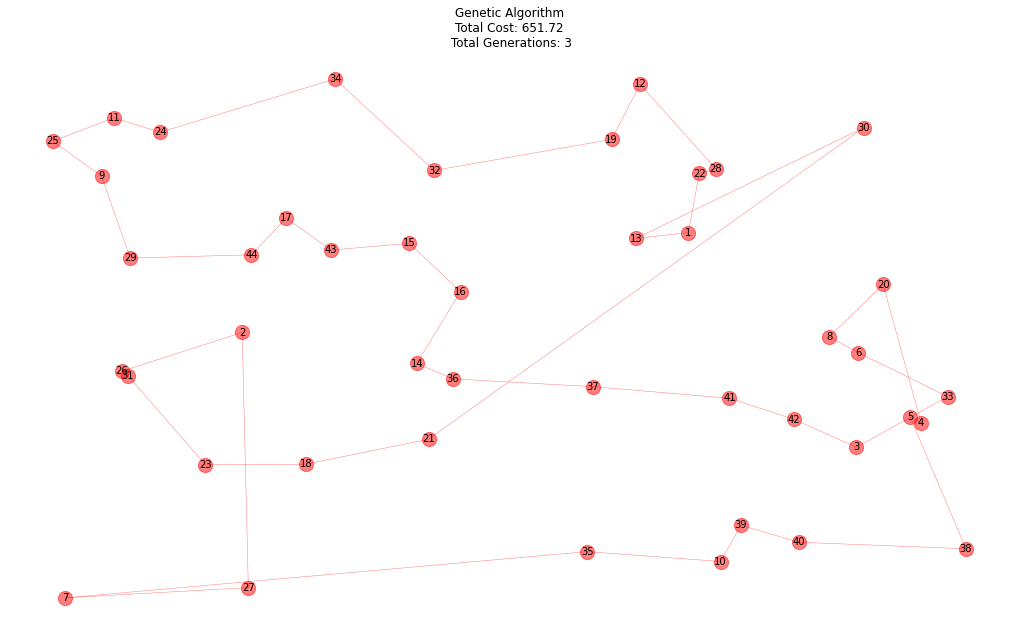

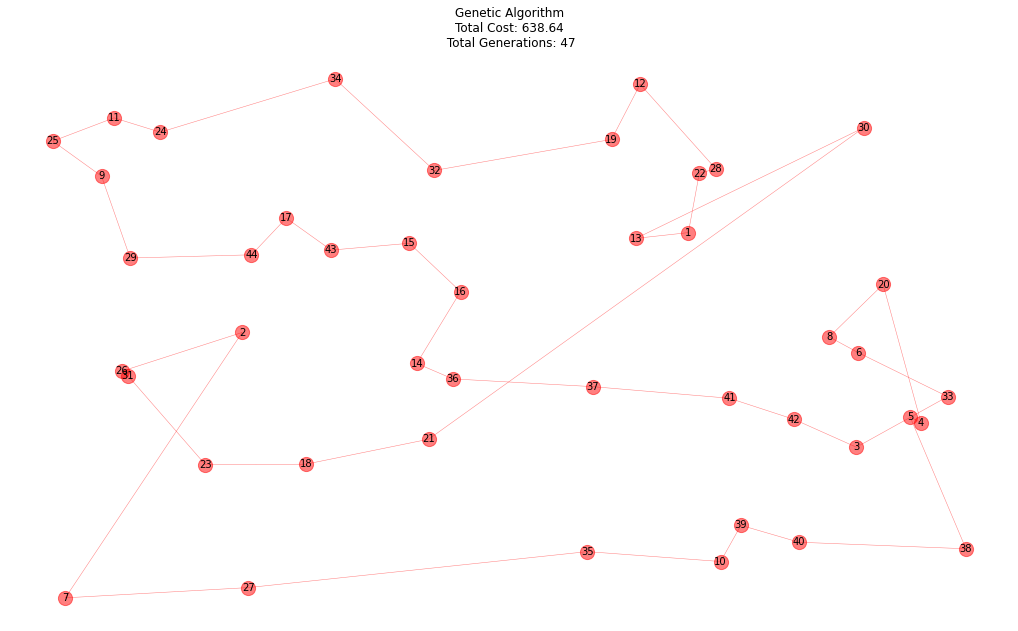

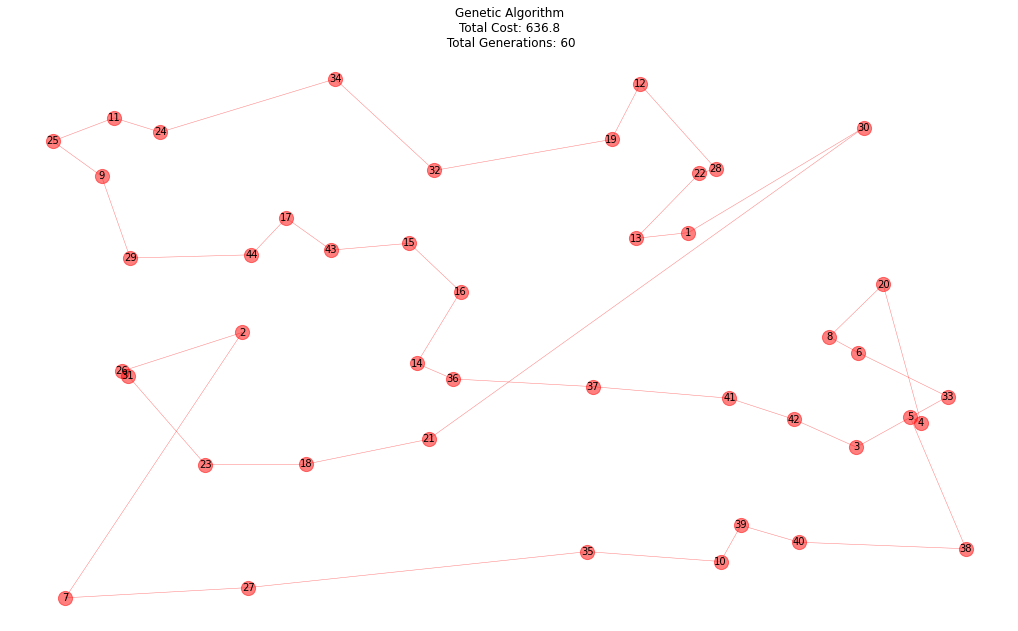

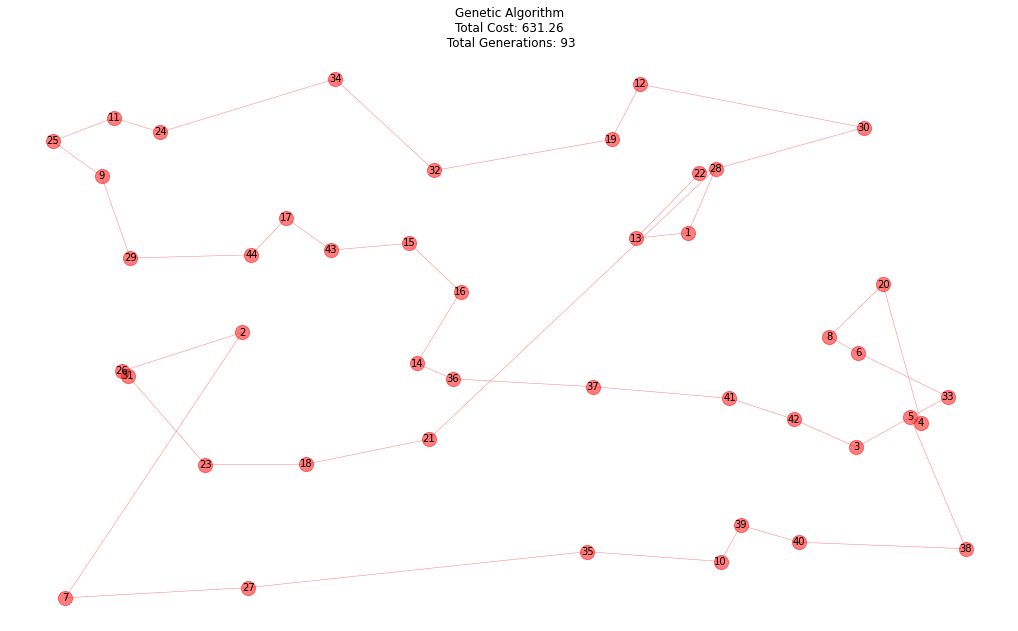

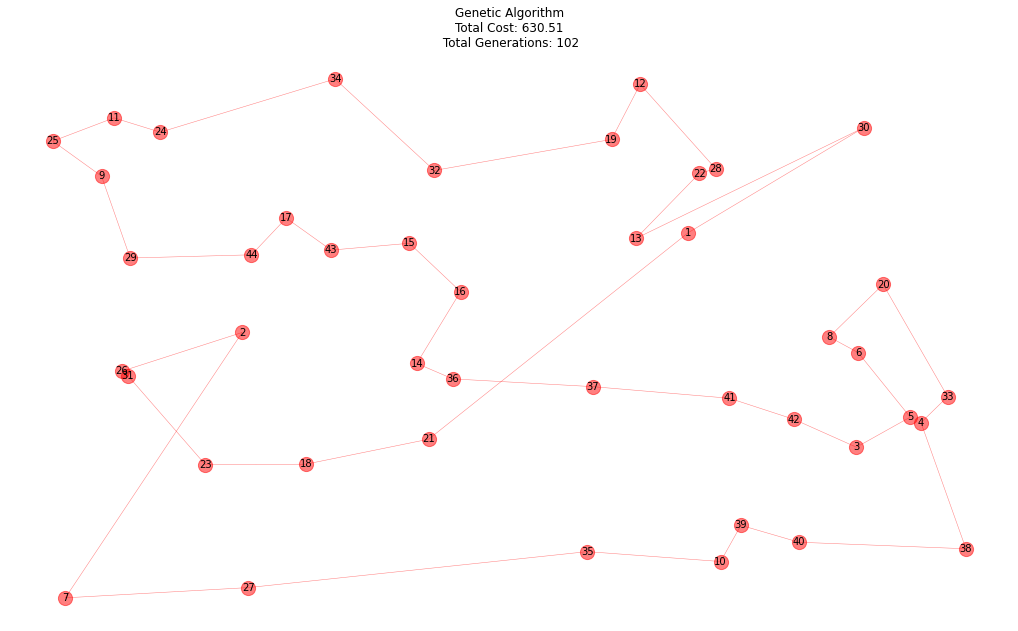

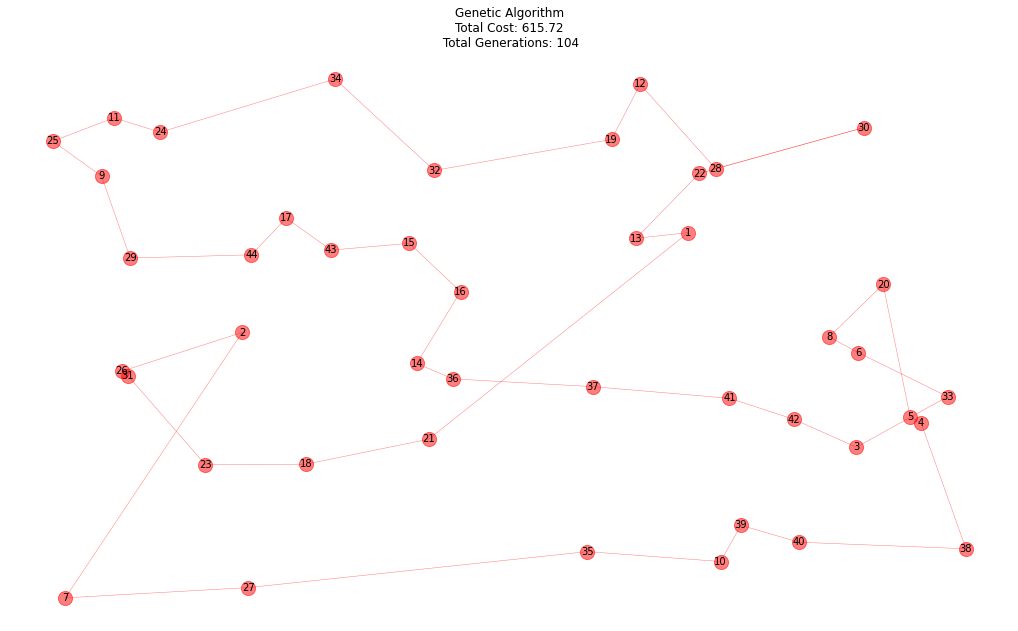

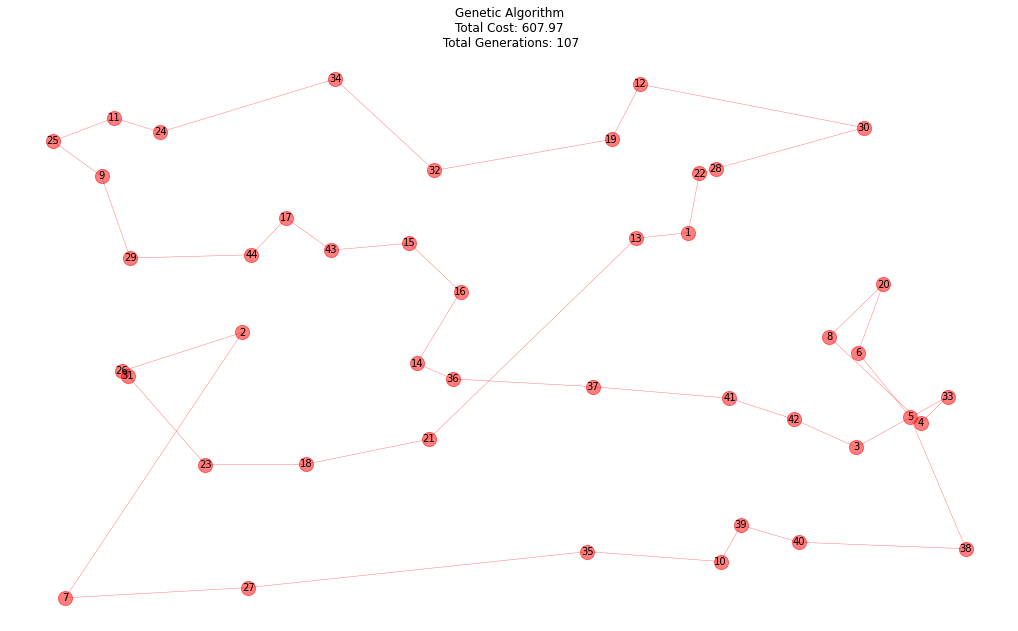

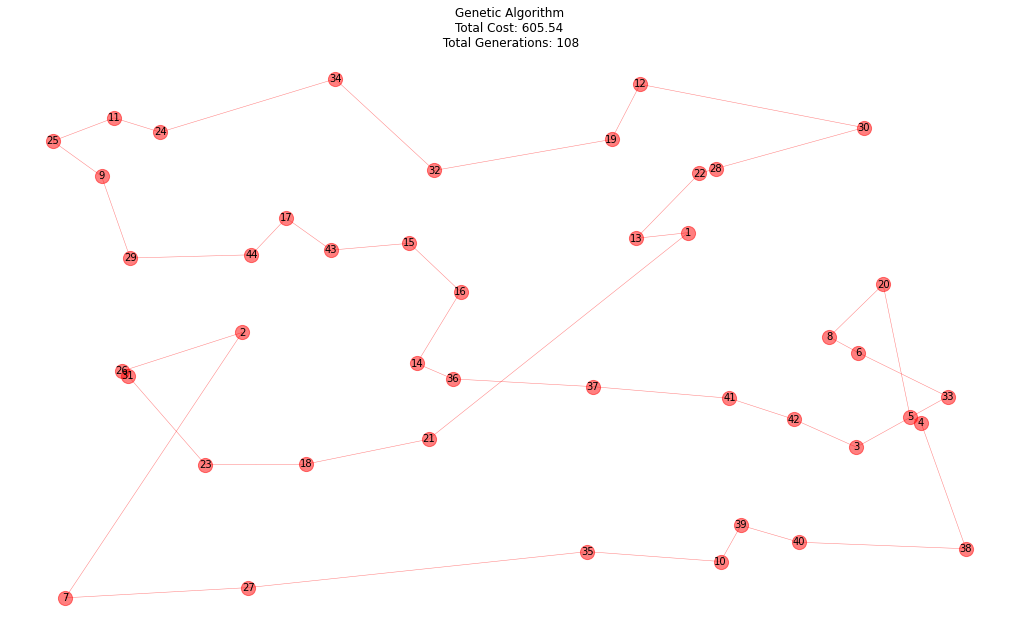

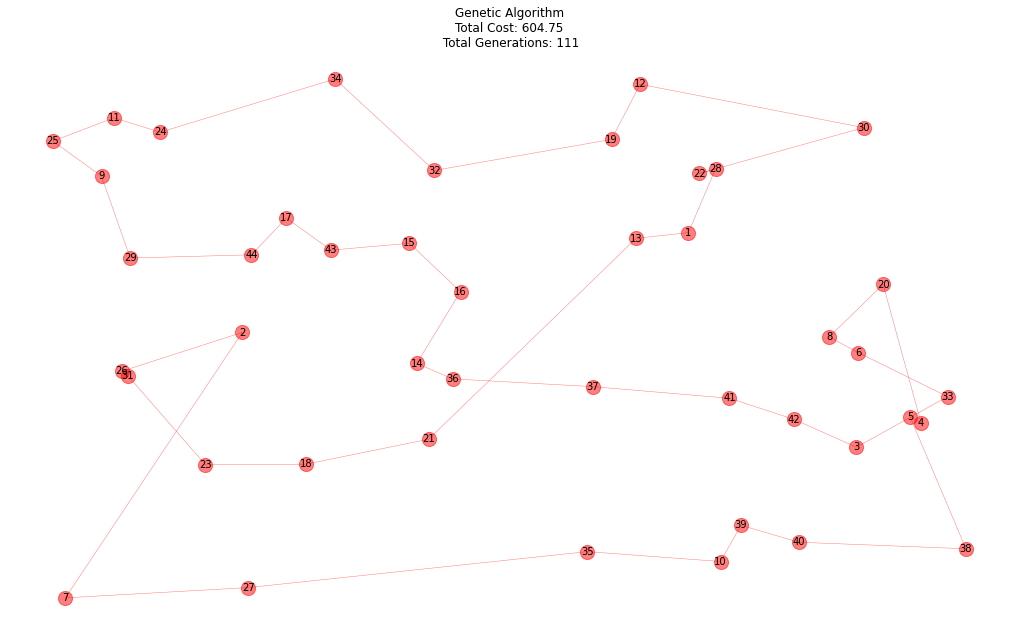

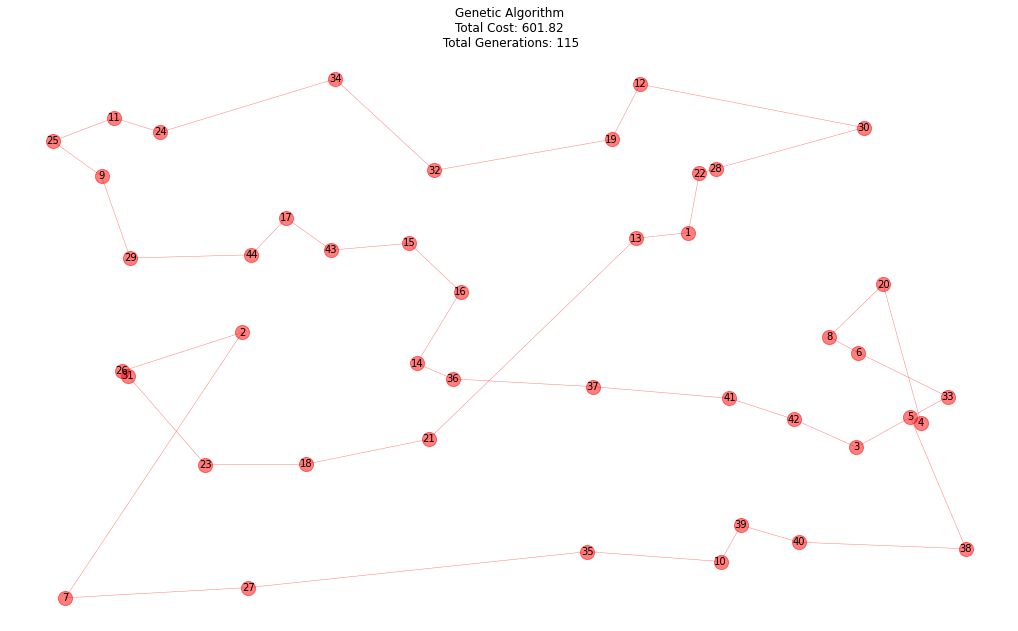

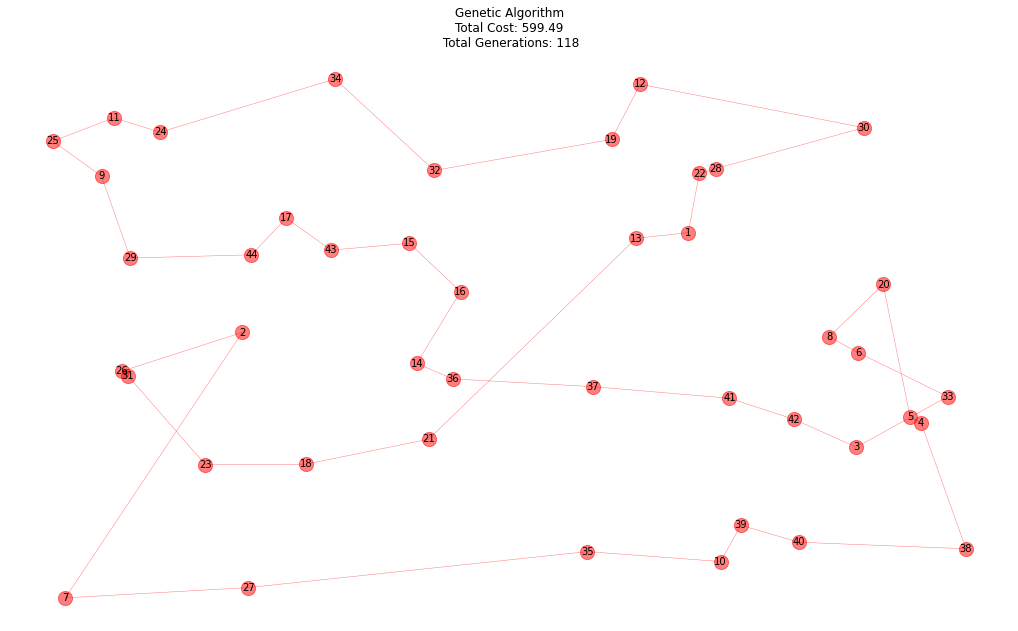

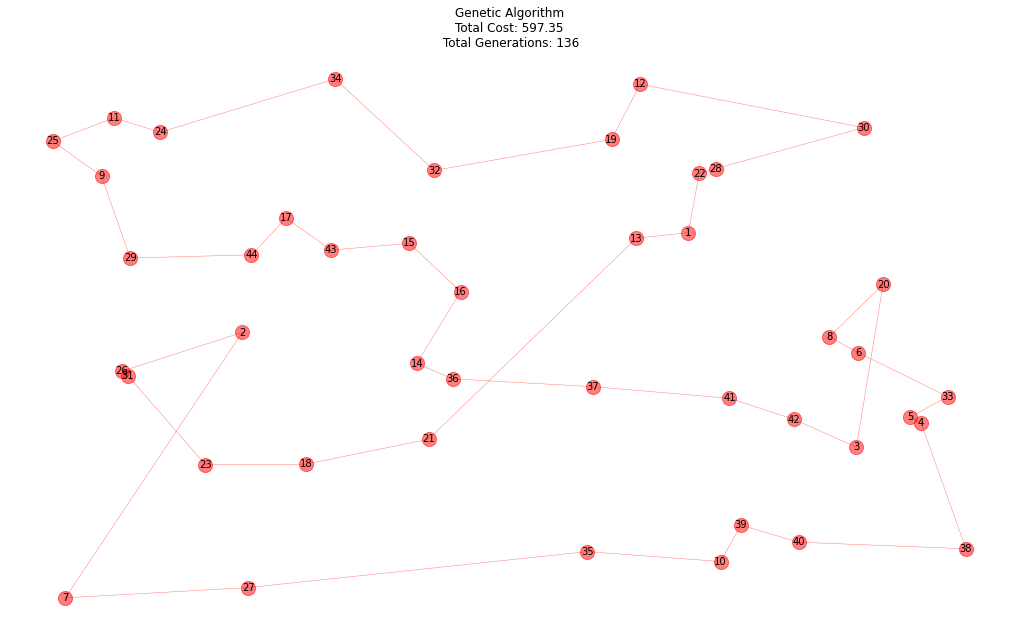

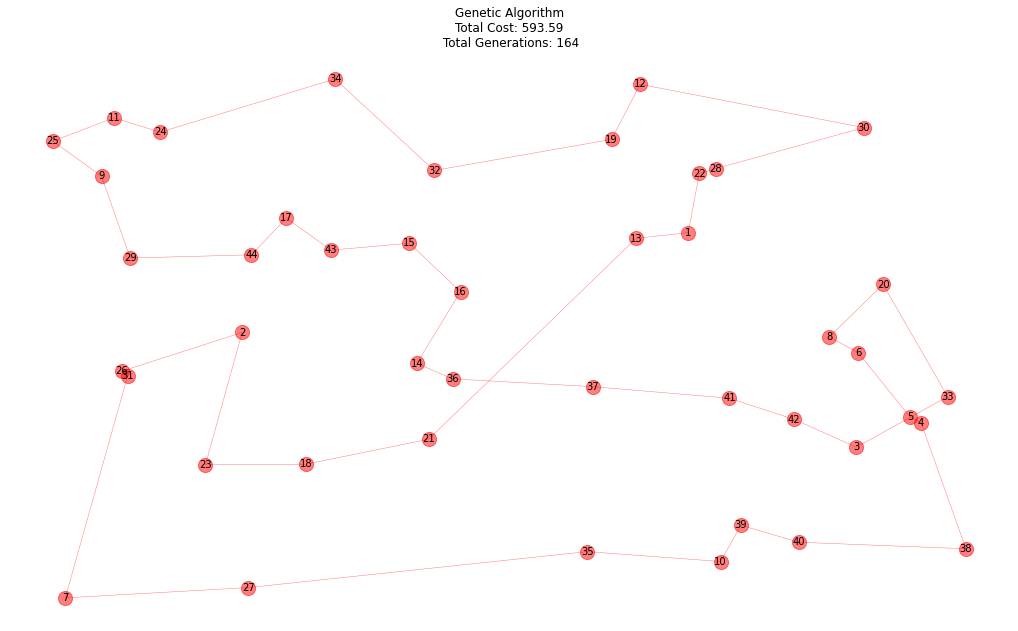

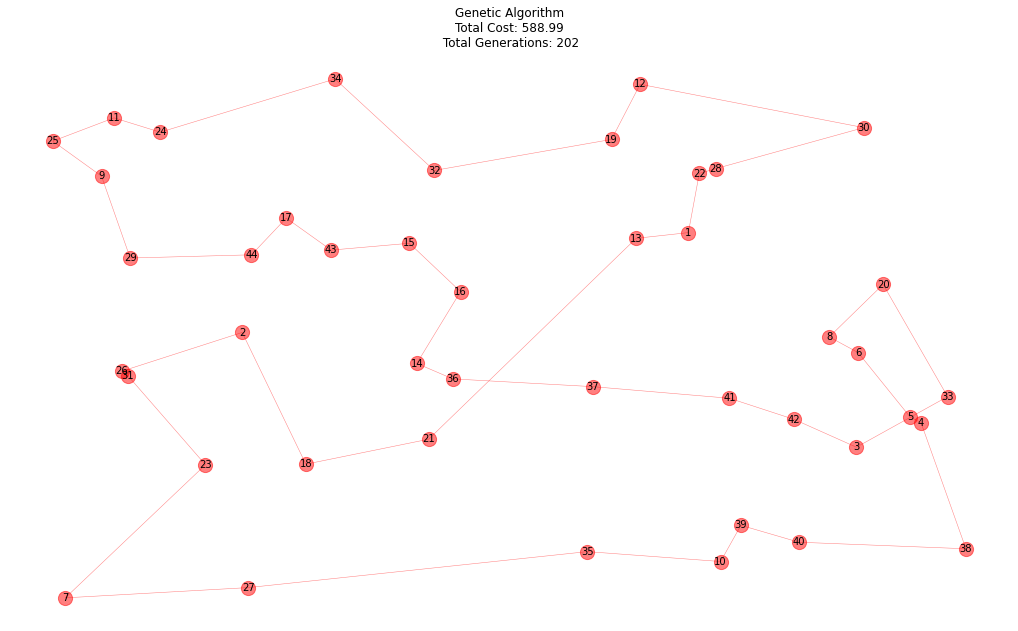

In [ ]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_44.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_44.gif?raw=1)


## TSP with 77 cities

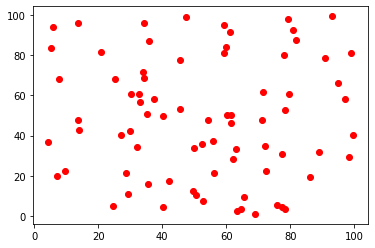

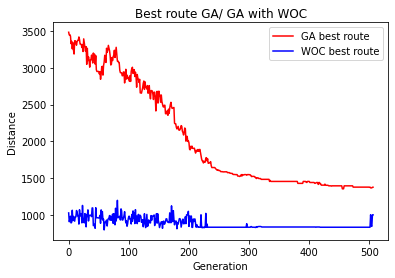

CPU times: user 5.62 s, sys: 10.6 ms, total: 5.63 s
Wall time: 5.63 s


In [ ]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random77.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(1914.77, 189)
(1056.05, 941)
(1595.59, 365)
(1299.45, 504)
(1438.26, 374)
(1335.86, 638)
2 loops, best of 3: 3.62 s per loop


### Best cost with WOC

In [ ]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(829.89, 41)
(830.4, 25)
(876.4, 6)
(794.94, 3)
(831.83, 20)
(816.49, 147)
2 loops, best of 3: 910 ms per loop


In [ ]:
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [1, 5, 3, 65, 39, 76, 10, 64, 57, 35, 24, 50, 38, 22, 46, 71, 16, 67, 56, 28, 9, 52, 68, 74, 62, 63, 14, 33, 47, 48, 44, 25, 70, 12, 32, 17, 6, 59, 72, 26, 2, 29, 75, 18, 54, 15, 69, 61, 8, 77, 34, 66, 13, 31, 53, 20, 27, 30, 7, 60, 45, 41, 49, 36, 4, 42, 21, 51, 37, 58, 11, 43, 40, 73, 55, 23, 19, 1]
Total cost: 809.29
Total number generations: 70


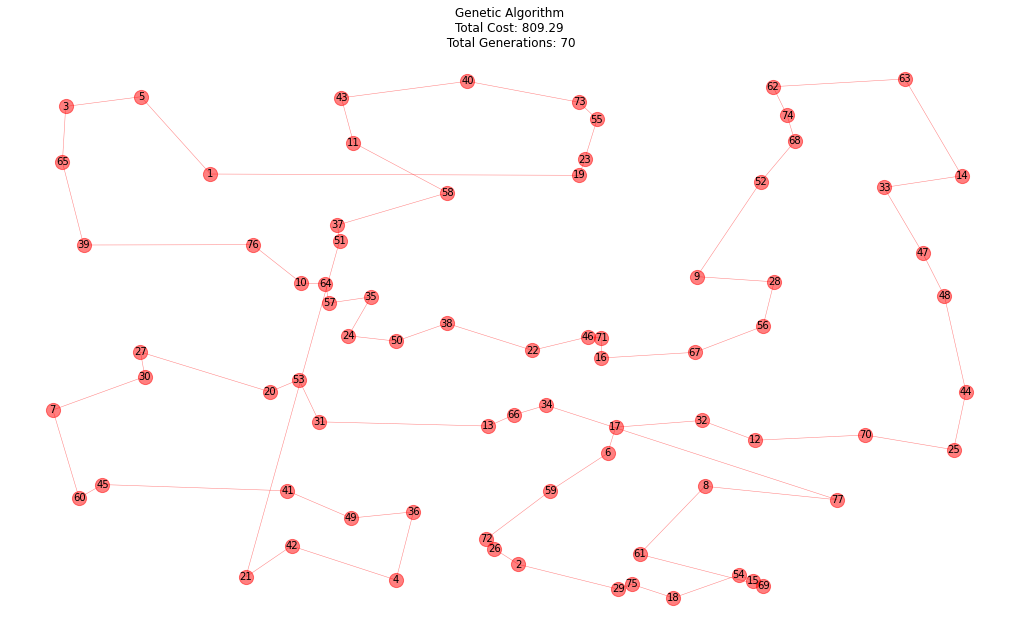

In [152]:
graph.draw_plot(results[0][-1], weights=False)

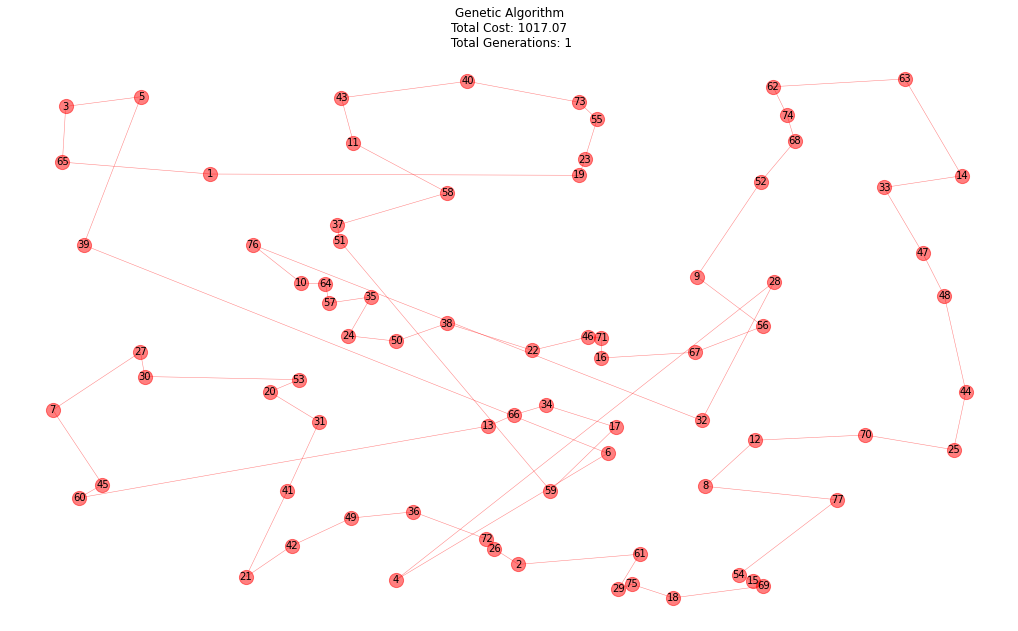

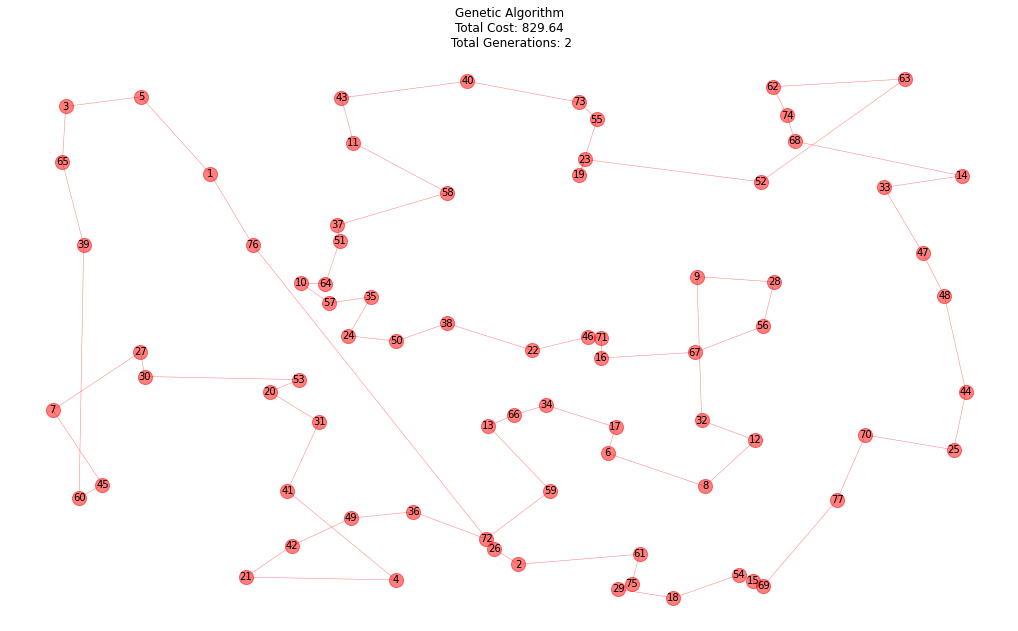

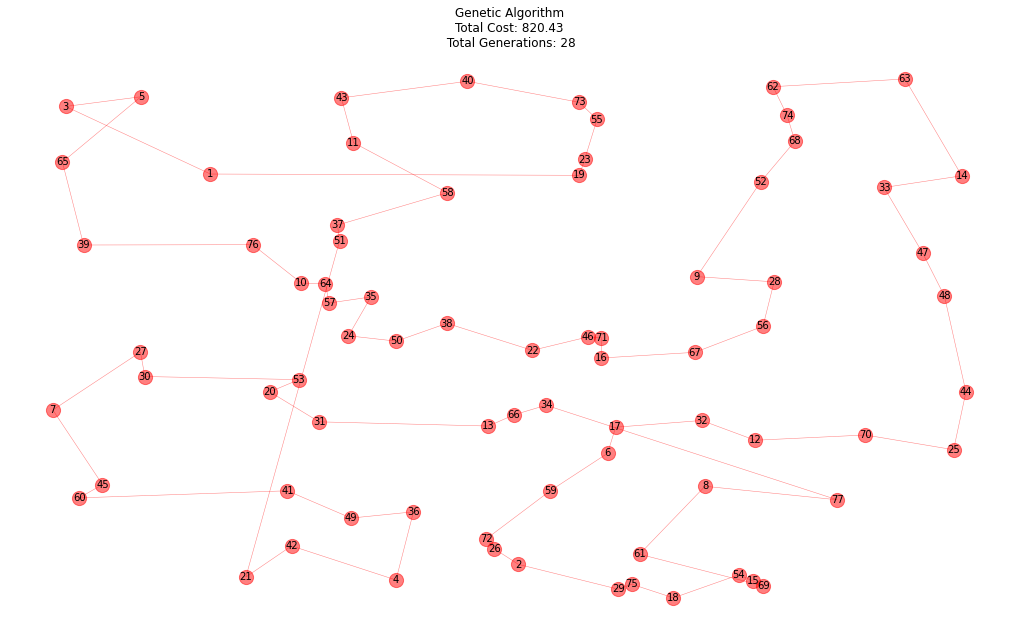

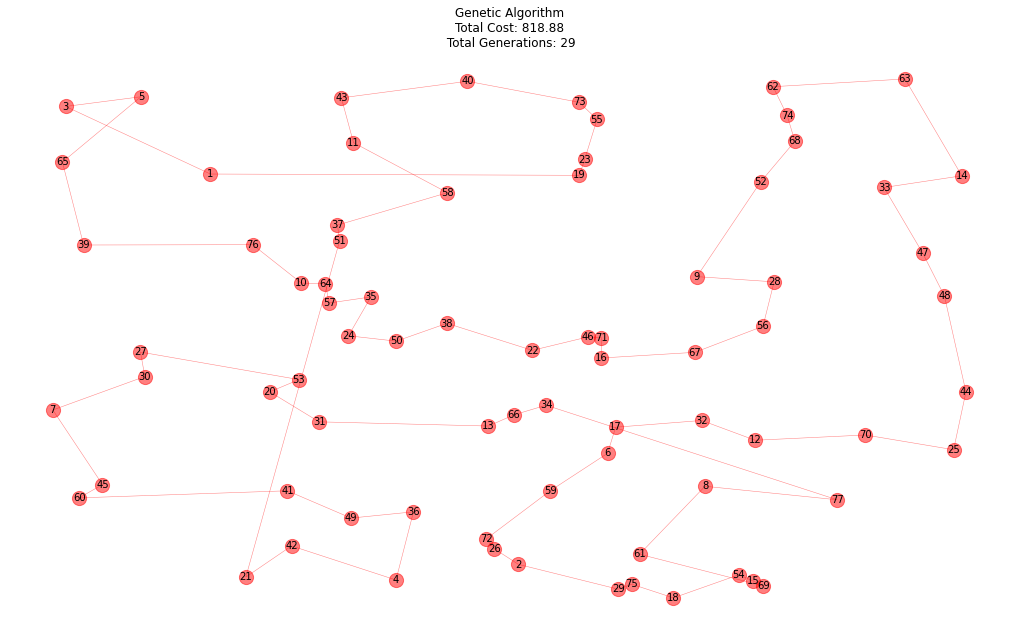

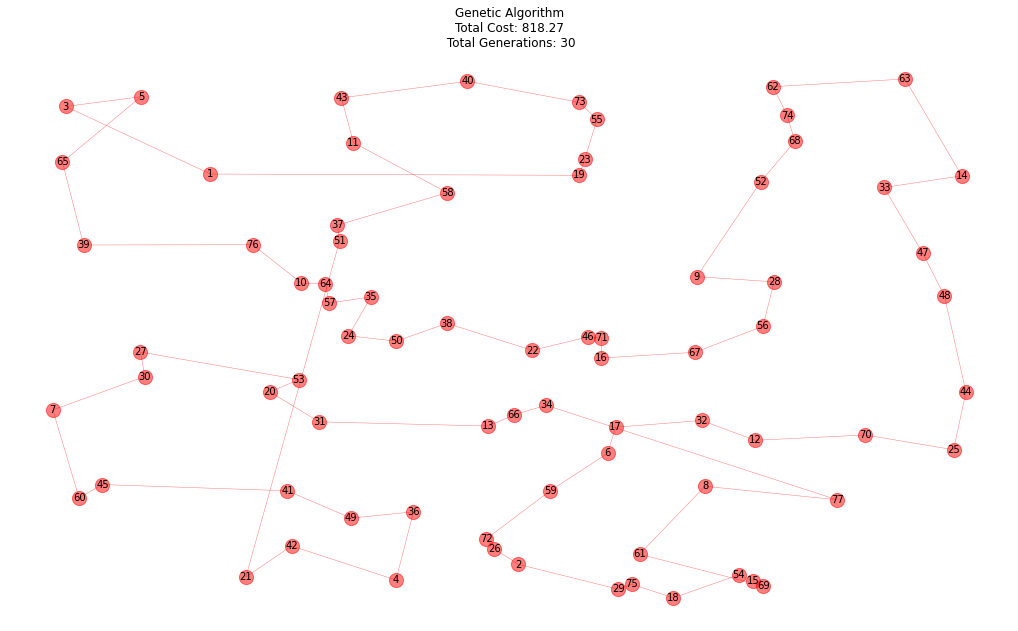

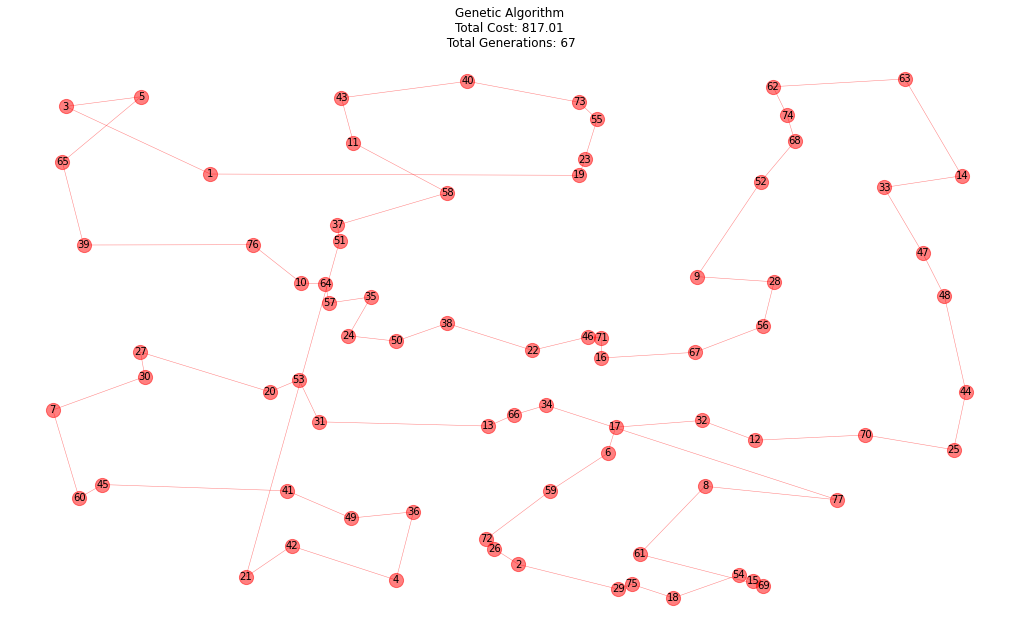

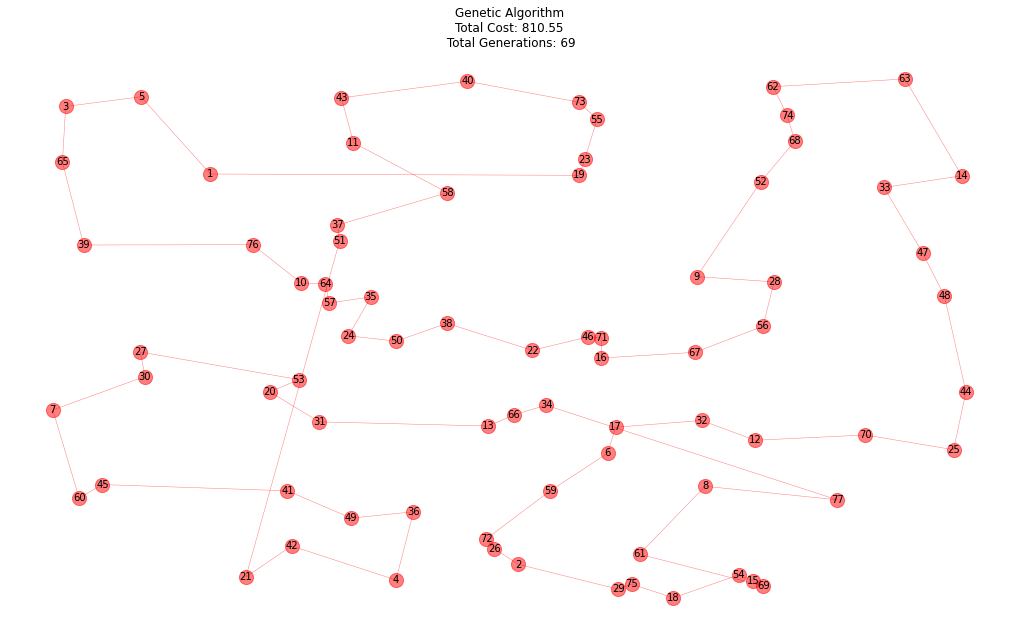

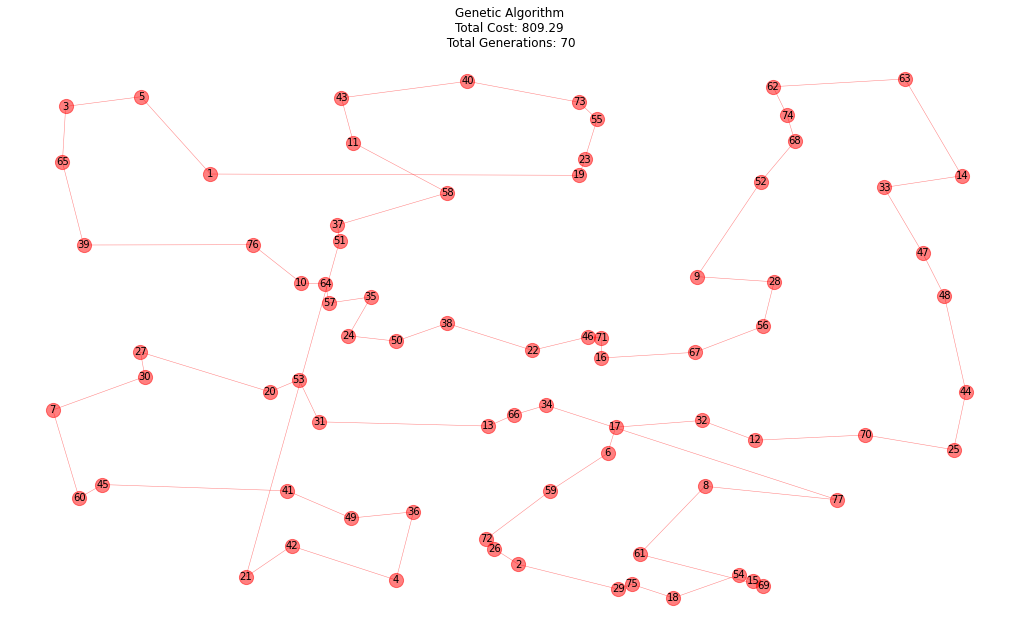

In [153]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_77.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_77.gif?raw=1)


## TSP with 97 cities

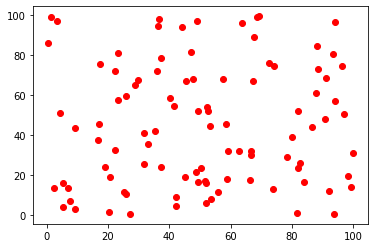

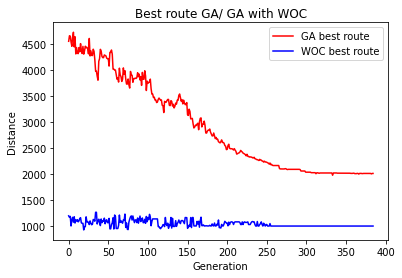

CPU times: user 6.52 s, sys: 10.9 ms, total: 6.53 s
Wall time: 6.54 s


In [184]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random97.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [185]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(2071.92, 586)
(2000.57, 416)
(2183.91, 412)
(1769.72, 591)
(2053.85, 620)
(1818.16, 624)
2 loops, best of 3: 5.89 s per loop


### Best cost with WOC

In [186]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(910.71, 88)
(910.01, 129)
(921.27, 9)
(911.92, 120)
(917.8, 50)
(916.16, 75)
2 loops, best of 3: 2.49 s per loop


In [192]:
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [86, 8, 68, 43, 15, 36, 5, 67, 1, 90, 16, 63, 95, 44, 17, 77, 30, 3, 13, 26, 37, 69, 41, 88, 84, 9, 73, 18, 57, 91, 29, 7, 31, 39, 55, 35, 54, 33, 28, 45, 14, 74, 2, 72, 10, 42, 24, 46, 21, 34, 4, 96, 94, 85, 53, 79, 82, 40, 50, 38, 93, 81, 60, 62, 48, 20, 51, 97, 23, 64, 80, 52, 25, 61, 65, 76, 27, 47, 19, 75, 6, 83, 70, 22, 78, 12, 32, 89, 49, 59, 71, 56, 58, 66, 11, 92, 87, 86]
Total cost: 903.98
Total number generations: 38


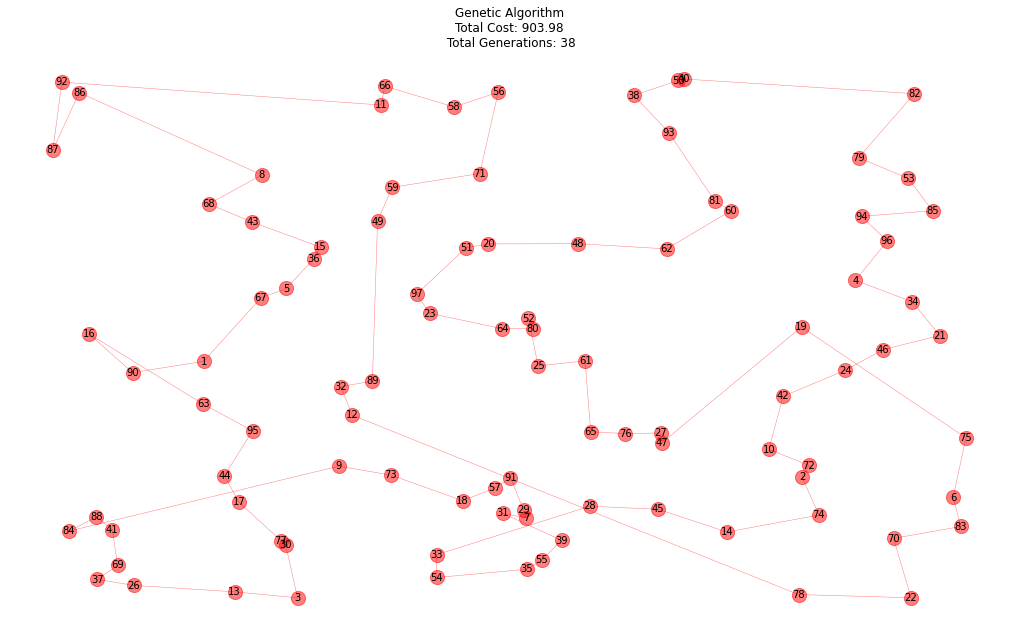

In [193]:
graph.draw_plot(results[0][-1], weights=False)

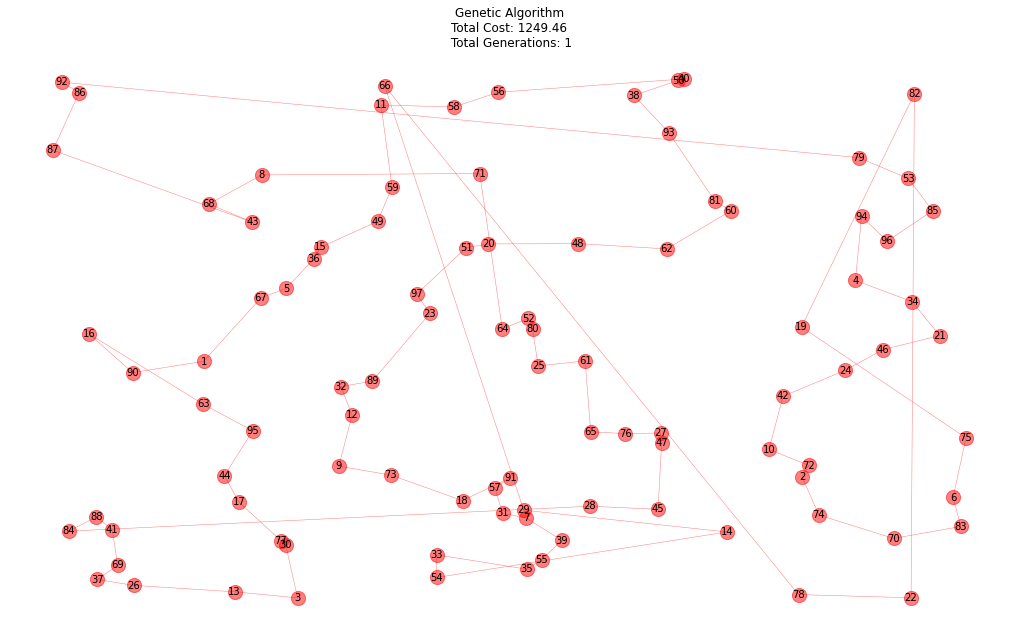

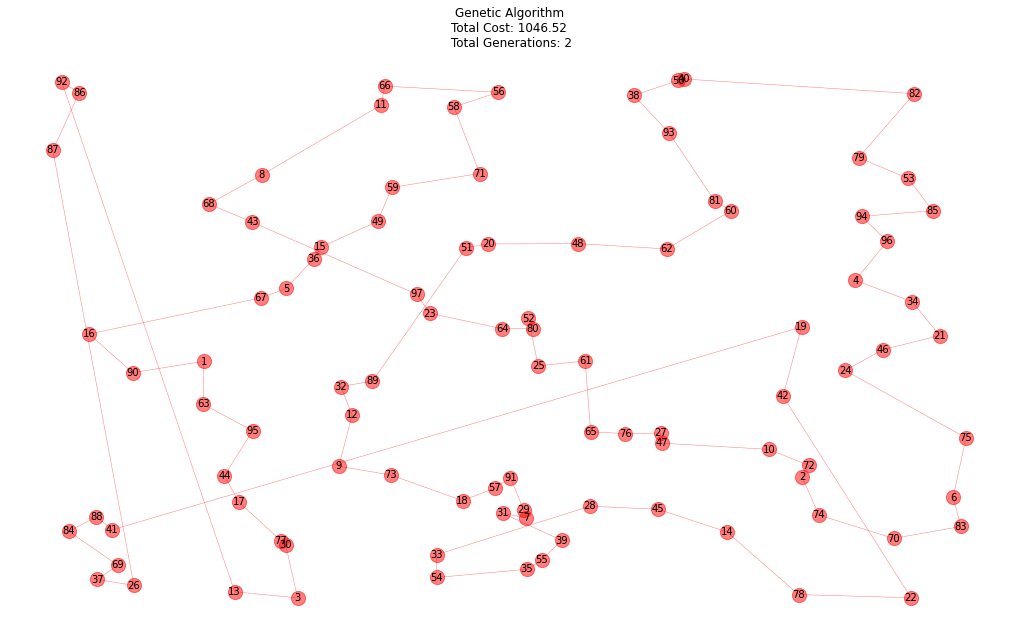

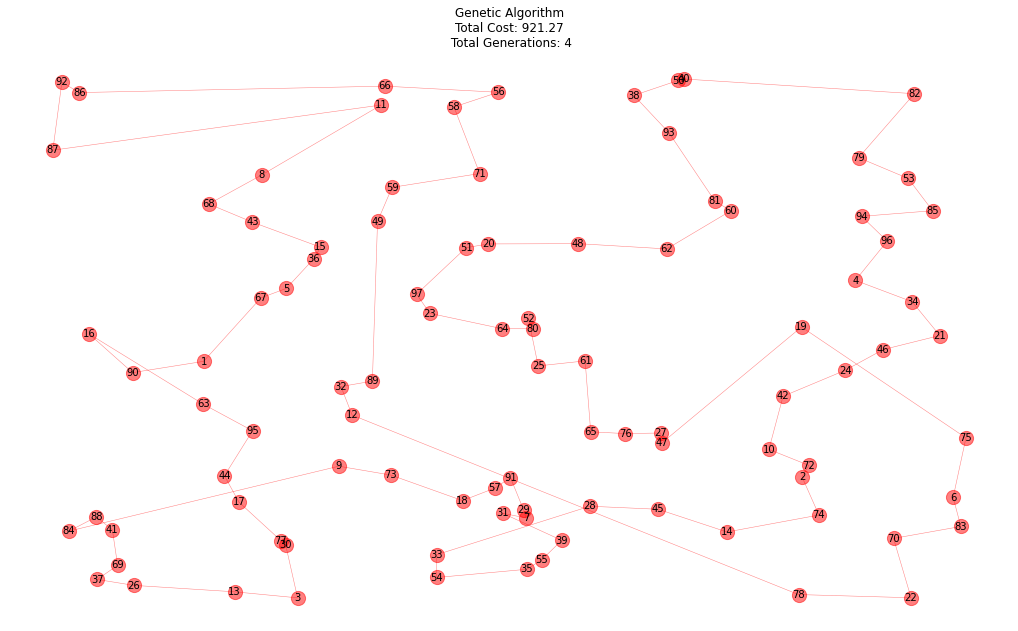

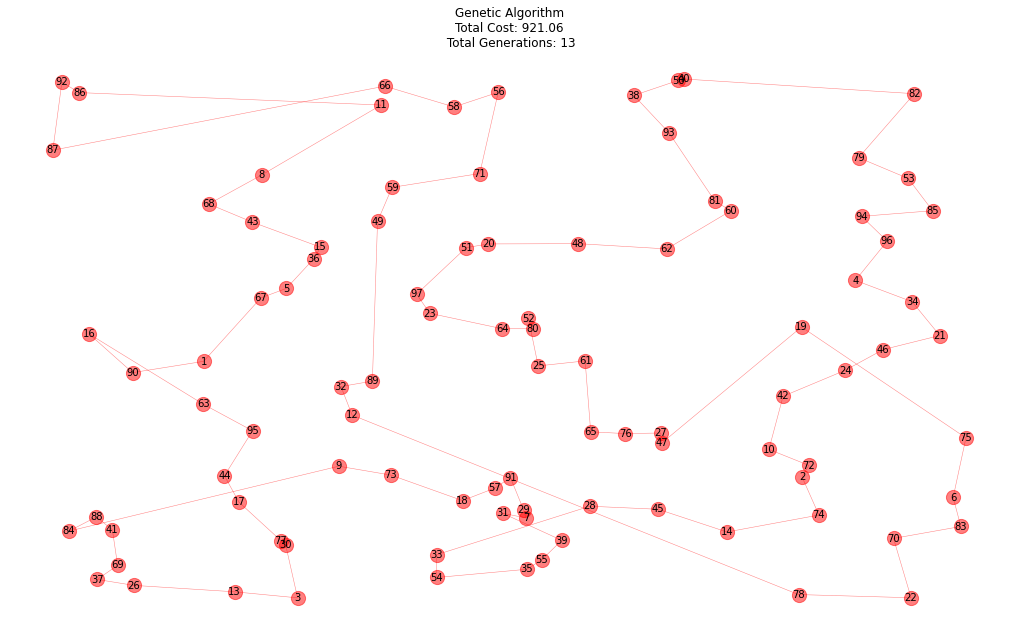

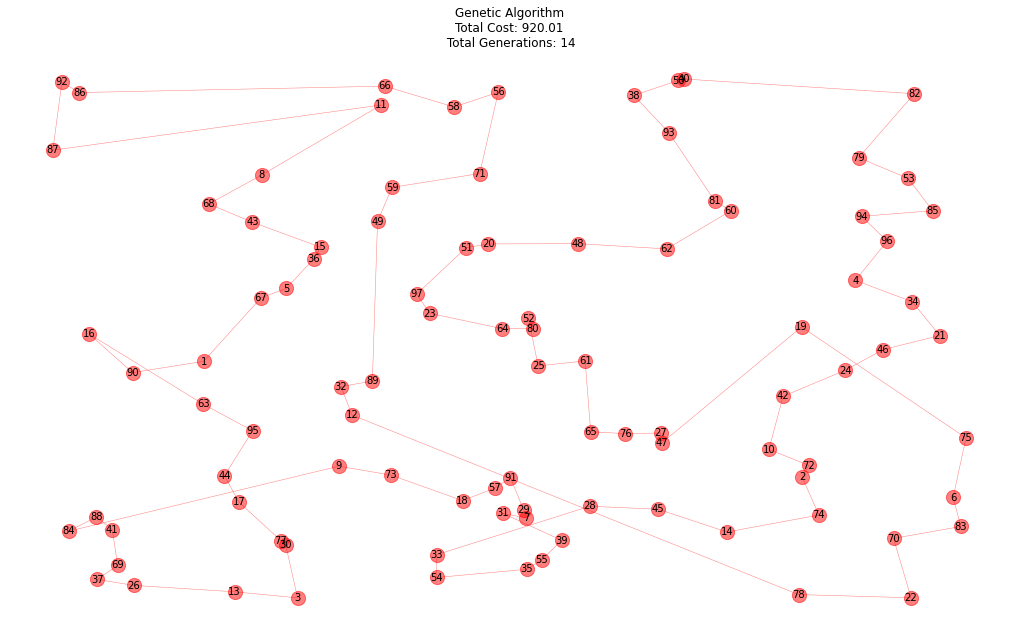

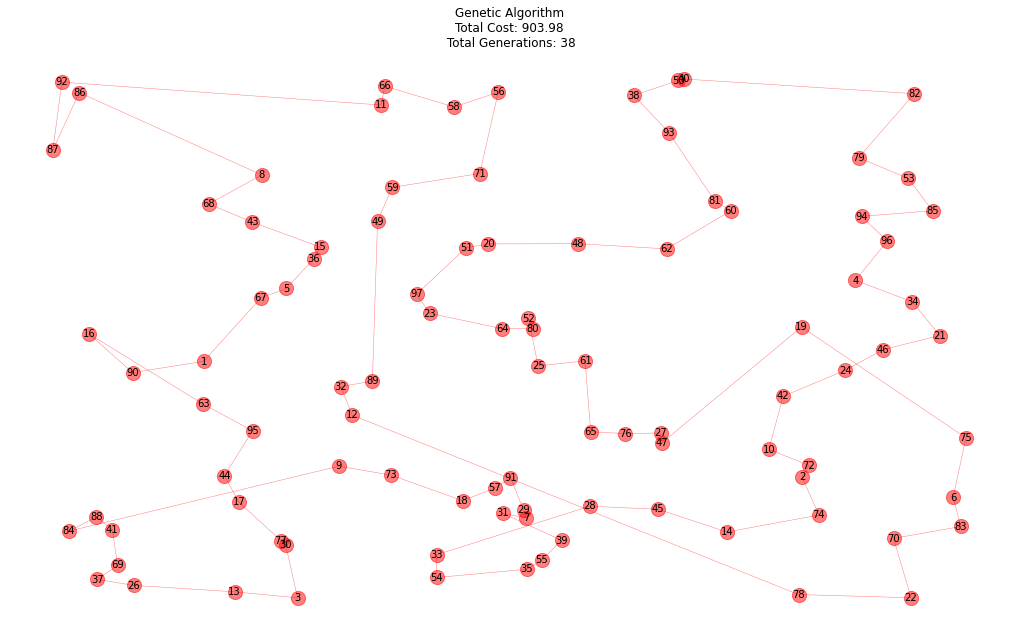

In [194]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_97.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_97.gif?raw=1)


## TSP with 222 cities

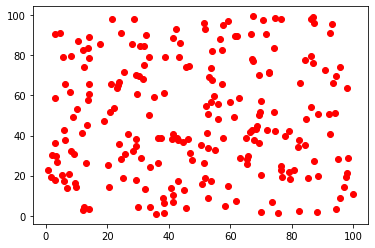

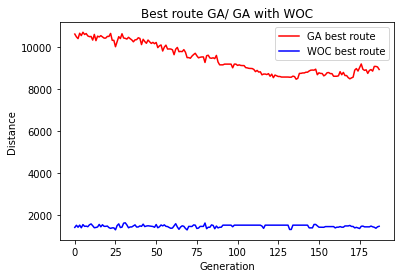

CPU times: user 17.6 s, sys: 21.4 ms, total: 17.6 s
Wall time: 17.6 s


In [160]:
%%time
# Find besth path by using nearest insertion algorithm
# Instantiate graph 
graph = Graph('Random222.tsp')
plot_nodes(graph)

# Run GA with WOC but not include tour to next generation 
# with population size 59 and stopping criteria 50 generation without cost improvement
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'guess')
plot_ga_and_woc(results)

### Best cost without WOC

In [161]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = False)
print(results[0][-1][1:])

(8560.87, 224)
(9800.01, 50)
(9839.74, 15)
(8998.81, 177)
(7199.01, 360)
(6996.17, 553)
2 loops, best of 3: 6.54 s per loop


### Best cost with WOC

In [162]:
%%timeit -n 2
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(results[0][-1][1:])

(1268.3, 21)
(1270.9, 43)
(1265.8, 68)
(1261.26, 107)
(1269.15, 2)
(1269.15, 2)
2 loops, best of 3: 5.62 s per loop


In [181]:
graph = Graph('Random222.tsp')
results = graph.genetic_algorithm(pop_size=50, term_count=50, woc = 'include')
print(f'The best route: {results[0][-1][0]}',\
      f'Total cost: {results[0][-1][1]}',\
      f'Total number generations: {results[0][-1][2]}', sep='\n')

The best route: [12, 11, 222, 97, 132, 156, 100, 54, 216, 103, 1, 70, 94, 65, 168, 136, 106, 170, 175, 122, 202, 73, 98, 64, 7, 167, 47, 176, 171, 221, 46, 20, 63, 201, 207, 181, 142, 75, 17, 78, 123, 129, 60, 55, 187, 177, 209, 83, 86, 49, 145, 45, 199, 163, 81, 149, 80, 173, 133, 185, 111, 130, 160, 110, 9, 120, 23, 139, 217, 205, 212, 42, 105, 150, 24, 59, 143, 109, 35, 14, 79, 21, 119, 39, 101, 69, 92, 164, 131, 19, 84, 158, 29, 154, 76, 141, 208, 161, 197, 189, 144, 184, 190, 48, 179, 192, 53, 31, 117, 157, 38, 18, 169, 193, 211, 15, 203, 104, 126, 147, 108, 93, 102, 172, 113, 138, 85, 114, 5, 44, 153, 25, 88, 116, 28, 148, 107, 146, 62, 180, 178, 165, 96, 36, 57, 200, 198, 37, 95, 166, 30, 125, 134, 4, 196, 58, 214, 127, 8, 67, 82, 22, 182, 219, 61, 128, 124, 159, 188, 195, 32, 51, 118, 71, 50, 6, 16, 41, 112, 2, 26, 218, 152, 43, 183, 72, 3, 186, 162, 13, 74, 137, 90, 52, 210, 213, 204, 194, 33, 115, 27, 77, 215, 135, 151, 191, 10, 99, 66, 140, 91, 89, 56, 34, 40, 206, 155, 87, 

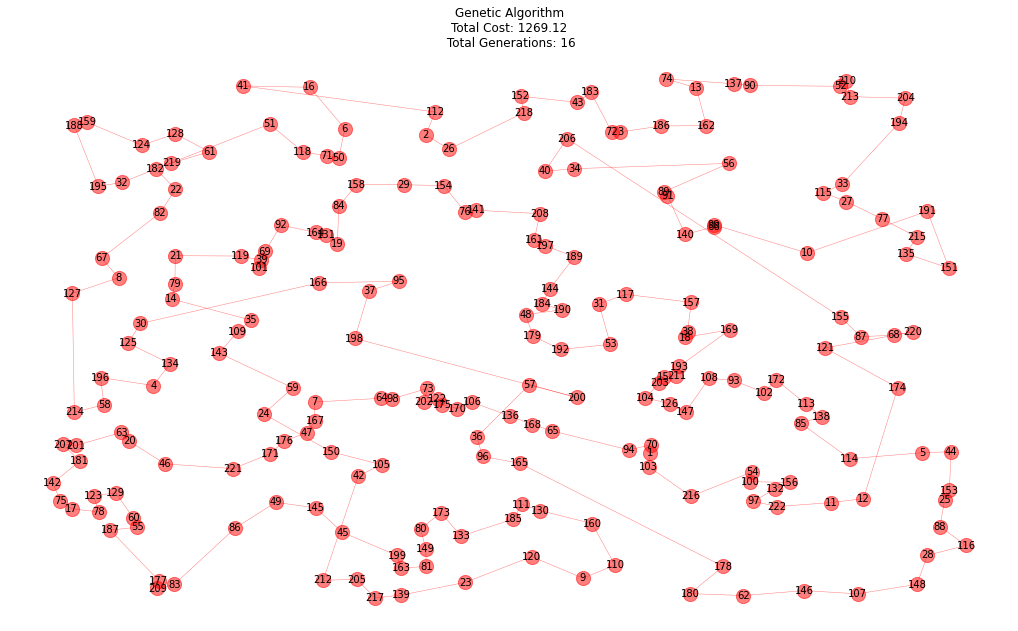

In [182]:
graph.draw_plot(results[0][-1], weights=False)

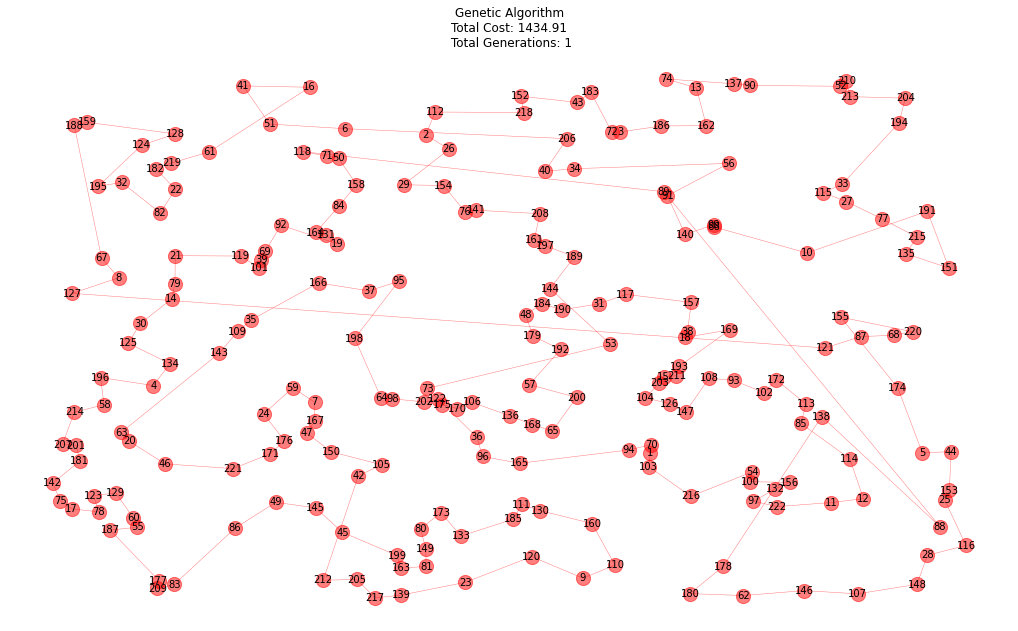

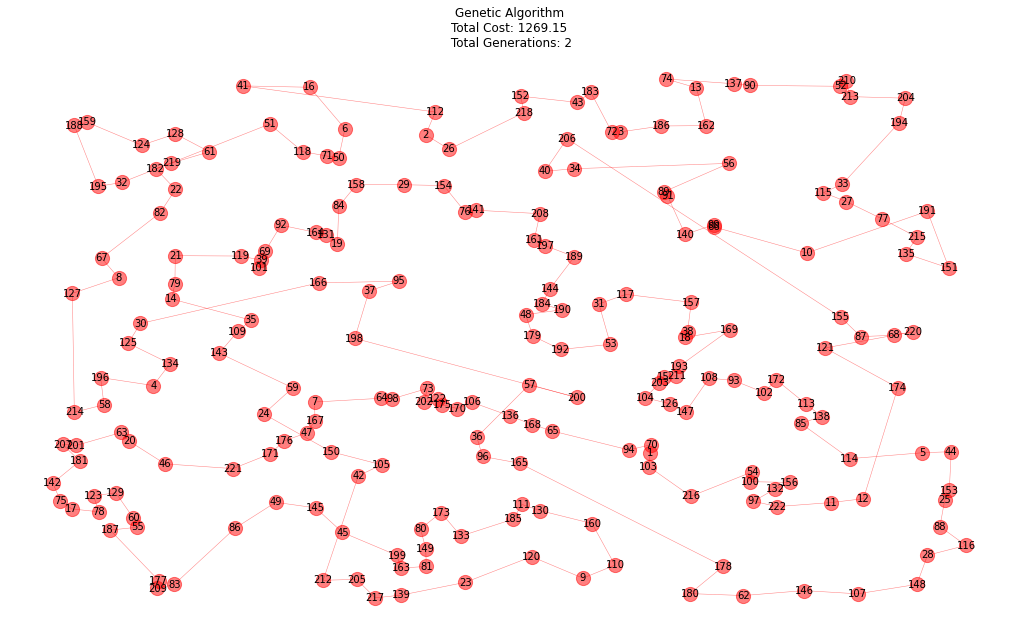

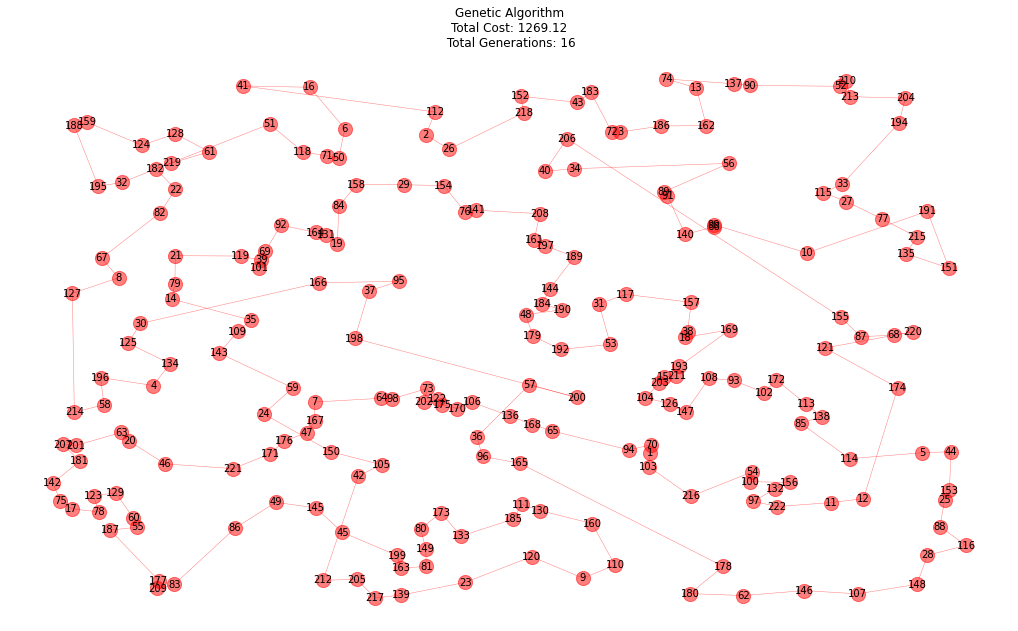

In [183]:
# Plot all paths in nearest insertion algorithm
# Reset index for file name and delete all images from graph directory
graph.reset_file_index()

for i in range(len(results[0])):
    graph.draw_plot(results[0][i], weights=False)

# Create gif image
create_gif('GA_with_WOC_222.gif')

![WOC Demo](https://github.com/DSNortsev/CSE545-Artificial-Intelligence/blob/master/Project5/GA_with_WOC_222.gif?raw=1)


In [ ]:
# # # Create pdf from Colab
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
# !pip install pypandoc > /dev/null 2>&1

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !cp drive/My\ Drive/Colab\ Notebooks/project4.ipynb ./

In [ ]:
# !jupyter nbconvert --to PDF "project4.ipynb" > /dev/null 2>&1